# Calibration, steady state computation, dynamic simulation for risk averse banking model

This notebook computes all statistics and figures in *Risk Averse Banks and Excess Reserve Fluctuation* by Brian C Jenkins and Michael K Salemi. The program uses the `fredpy` package (https://github.com/letsgoexploring/fredpy-package)to download data from FRED. The model is approximated to 3rd-order using Dynare++ (http://www.dynare.org/documentation-and-support/dynarepp) with assistance from the `dynarehelper` package (https://github.com/letsgoexploring/dynarehelper-package). `dynarehelper` is known to work on systems running macOS High Sierra and GNU Octave, version 4.2.1. There no warranties for other configurations.

In [1]:
import fredpy as fp
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import fsolve
from scipy.special import erf, erfc
from scipy.stats import lognorm
import dynarehelper as dh
%matplotlib inline

import matplotlib 
matplotlib.rc('xtick', labelsize=15) 
matplotlib.rc('ytick', labelsize=15) 

/Users/brianjenkins/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


## Figure: Biweekly excess reserve balances in the US during the financial crisis

Download excess reserve data from FRED and construct a plot of the level of excess reserves and the biweekly percentage change.

In [2]:
excess_reserves = fp.series('EXCSRESNW')
excess_reserves_pc = fp.series('EXCSRESNW')

excess_reserves_pc = excess_reserves_pc.pc(log=False)
excess_reserves = excess_reserves.window(['01-01-2004','12-31-2011'])

excess_reserves,excess_reserves_pc = fp.window_equalize([excess_reserves,excess_reserves_pc])

print('First observation: ',excess_reserves.dates[0])
print('Last observation:  ',excess_reserves.dates[-1])

er_data =  pd.DataFrame({'level':excess_reserves.data,'pc':excess_reserves_pc.data},index=pd.to_datetime(excess_reserves.dates))
er_data = er_data[er_data.pc!=0]

First observation:  2004-01-07
Last observation:   2011-12-28


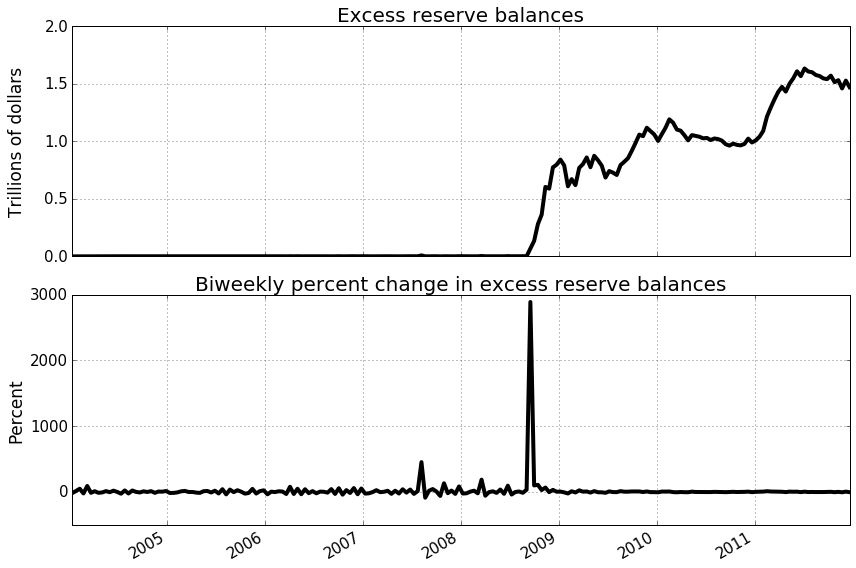

In [3]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(2,1,1)
plt.plot_date(er_data.index,er_data.level/1000/1000,'-k',lw=4)
ax.set_title('Excess reserve balances',fontsize=20)
ax.set_ylabel('Trillions of dollars',fontsize=17,labelpad=18)
ax.set_ylim([0,2])
ax.grid()
ax = fig.add_subplot(2,1,2)
plt.plot_date(er_data.index,er_data.pc,'-k',lw=4)
ax.set_title('Biweekly percent change in excess reserve balances',fontsize=20)
ax.set_ylabel('Percent',fontsize=17)
# ax.set_xlabel('Date',fontsize=17,labelpad=20)
ax.set_yticks([0,1000,2000,3000])
ax.set_ylim([-500,3000])
ax.grid()

fig.autofmt_xdate()
fig.tight_layout()

In [4]:
# Print date and value of maximum biweekly percent change
argmax = np.argmax(er_data.pc)
argmax
print(str(argmax)[:10],er_data.pc.loc[argmax])

2008-09-17 2889.60352423


## Data for calibration

To calibrate the model, the following quantities for the US economy are needed:

* Investment to GDP ratio ($I/Y^f$)
* Government consumption to GDP ratio ($G/Y^f$)
* Quarterly capital depreciation rate ($\delta$)
* Coefficient of autocorrelation for log deviation of TFP from steady state ($\rho_z$)
* Standard deviation of shock to log deviation of TFP from steady state ($\sigma_z$)
* Coefficient of autocorrelation for log deviation of government consumption from steady state ($\rho_g$)
* Standard deviation of shock to log deviation of government consumption from steady state ($\sigma_g$)
* Average share of workers' time spent working ($H$)
* Capital to net worth ratio ($K/N$)
* Average nominal interest on short-term government bonds ($R^n$)
* Average nominal interest on bank deposits ($R^D$)
* Average inflation ($\Pi$)
* Average excess reserve to deposit ratio ($M^{ex}/D$)

All data are retreived from FRED using the `fredpy` Python package.

### Capital, TFP, and government consumption

First, use data from FRED to compute the ratios $I/Y^f$ and $G/Y^f$. Calibrate $\delta$ using data on annual capital depreciation. Then use the perpetual inventory method (See Timothy Kehoe's notes: http://users.econ.umn.edu/~tkehoe/classes/GrowthAccountingNotes.pdf) to compute an implied series for the capital stock. Use computed capital series to compute a series for TFP. Apply the HP filter to the computed log TFP series and log per capita government consumption and estimate AR(1) models for each.

Avg depreciation-GDP ratio:                0.13816
Avg investment-GDP ratio (saving rate):    0.16962
Avg government consumption-GDP ratio:        0.20457
Avg annual dep rate:                       0.10901
Annual data date range:                    Range: 1947-01-01 to 2016-01-01
Quarterly data date range:                 Range: 1947-01-01 to 2017-10-01


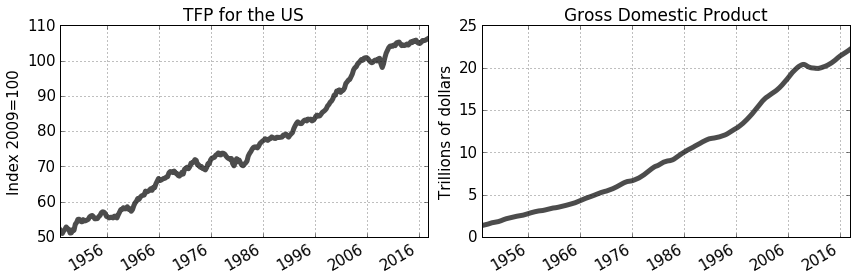

In [5]:
# Download nominal GDP, nominal personal consumption expenditures, nominal gross private domestic investment, nominal 
# government consumption, an index of hours worked in the nonfarm business sector produced by the BLS, and the GDP 
# deflator. All data are quarterly.
gdp = fp.series('GDP')
consumption = fp.series('PCEC')
investment = fp.series('GPDI')
government = fp.series('GCE')
hours = fp.series('HOANBS')
deflator = fp.series('GDPDEF')

# Make sure that all of the downloaded fp.series instances have the same date ranges
gdp,consumption,investment,government,hours,deflator = fp.window_equalize([gdp,consumption,investment,government,hours,deflator])

# Compute real GDP, real consumption, real investment. Note GDP = consumption+investment+government
gdp.data = (consumption.data+investment.data+government.data)/deflator.data*100
consumption.data = consumption.data/deflator.data*100
investment.data = investment.data/deflator.data*100
government.data = government.data/deflator.data*100

# Set the capital share of income
alpha = 0.35

# Average saving rate (investment-GDP ratio)
i_yf_ratio = np.mean(investment.data/gdp.data)

# Average government consumption-GDP ratio
g_yf_ratio = np.mean(government.data/gdp.data)

# Average quarterly labor hours growth rate
n = ((hours.data[-1]/hours.data[0])**(1/(len(hours.data)-1)) - 1)*4

# Average quarterly real GDP growth rate
g = (((gdp.data[-1]/gdp.data[0])**(1/(len(gdp.data)-1)) - 1))*4 - n

# Compute annual depreciation rate
depA = fp.series('M1TTOTL1ES000')
gdpA = fp.series('gdpa')
consumptionA = fp.series('PCECA')
investmentA = fp.series('GPDIA')
governmentA = fp.series('GCEA')

gdpA = gdpA.window(['01-01-1947','01-01-2222'])
gdpA,consumptionA,investmentA, governmentA, depA = fp.window_equalize([gdpA,consumptionA,investmentA, governmentA, depA])

gdpA.dta = consumptionA.data + investmentA.data+governmentA.data

gdpA = gdpA.window([gdp.dates[0],gdp.dates[-1]])
gdpA,depA = fp.window_equalize([gdpA,depA])

deltaKY = np.mean(depA.data/gdpA.data)
delta = (n+g)*(deltaKY/(i_yf_ratio-deltaKY)-1)/4

# print calibrated values:
print('Avg depreciation-GDP ratio:               ',round(deltaKY,5))
print('Avg investment-GDP ratio (saving rate):   ',round(i_yf_ratio,5))
print('Avg government consumption-GDP ratio:       ',round(g_yf_ratio,5))
print('Avg annual dep rate:                      ',round(4*delta,5))
print('Annual data date range:                   ',gdpA.daterange)
print('Quarterly data date range:                ',gdp.daterange)

# Construct the capital fp.series. Note that the GPD and investment data are reported on an annualized basis
# so divide by 4 to get quarterly data.
capital = np.zeros(len(gdp.data))
capital[0] = gdp.data[0]/4*i_yf_ratio/(n+g+delta)

for t in range(len(gdp.data)-1):
    capital[t+1] = investment.data[t]/4 + (1-delta)*capital[t]

# Save in a fredpy fp.series
capital = fp.toFredSeries(data = capital,dates =gdp.dates,units = gdp.units,title='Capital stock for the US',freq='Quarterly')

# Compute TFP

tfp = gdp.data/capital.data**alpha/hours.data**(1-alpha)
tfp = fp.toFredSeries(data = tfp,dates =gdp.dates,units = hours.units,title='TFP for the US',freq='Quarterly')
tfp_2009 = (tfp.data[tfp.dates.index('2009-01-01')]+tfp.data[tfp.dates.index('2009-04-01')]+tfp.data[tfp.dates.index('2009-07-01')]+tfp.data[tfp.dates.index('2009-10-01')])/4
tfp.data = tfp.data/tfp_2009*100

fig = plt.figure(figsize=(12,4))

ax = fig.add_subplot(1,2,1)
plt.plot_date(tfp.dates,tfp.data,'-k',lw=5,alpha = 0.7)
plt.grid()
plt.ylabel(tfp.units,fontsize=15)
plt.title(tfp.title,fontsize=17)

ax = fig.add_subplot(1,2,2)
plt.plot_date(capital.dates,capital.data/1000,'-k',lw=5,alpha = 0.7)
plt.grid()
plt.ylabel('Trillions of dollars',fontsize=15)
plt.title(gdp.title,fontsize=17)

fig.autofmt_xdate()
fig.tight_layout()

In [6]:
# Convert each series into per capita using civilian pop 16 and over
government = government.percapita(civ_pop=True)

# Make sure TFP series has same length as the rest (since the .percapita() function may affect the date range.
tfp,government = fp.window_equalize([tfp,government])

# Compute and plot log real GDP, log consumptionumption, log investmentment, log hours
government_log = government.log()
tfp_log = tfp.log()

# HP filter to isolate trend and cyclical components
government_log_cycle,government_log_trend = government_log.hpfilter()
tfp_log_cycle,tfp_log_trend = tfp_log.hpfilter()

# Construct DataFrame
ts_data = pd.DataFrame({'tfp':tfp_log_cycle.data,'government':government_log_cycle.data},index=pd.to_datetime(tfp_log_cycle.dates))

ts_data['government_lag'] = ts_data['government'].shift(1)
ts_data['tfp_lag'] = ts_data['tfp'].shift(1)
ts_data = ts_data.dropna()

                            OLS Regression Results                            
Dep. Variable:                    tfp   R-squared:                       0.633
Model:                            OLS   Adj. R-squared:                  0.632
Method:                 Least Squares   F-statistic:                     477.6
Date:                Tue, 06 Feb 2018   Prob (F-statistic):           3.15e-62
Time:                        16:34:52   Log-Likelihood:                 996.38
No. Observations:                 278   AIC:                            -1991.
Df Residuals:                     277   BIC:                            -1987.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
tfp_lag        0.7918      0.036     21.854      0.0

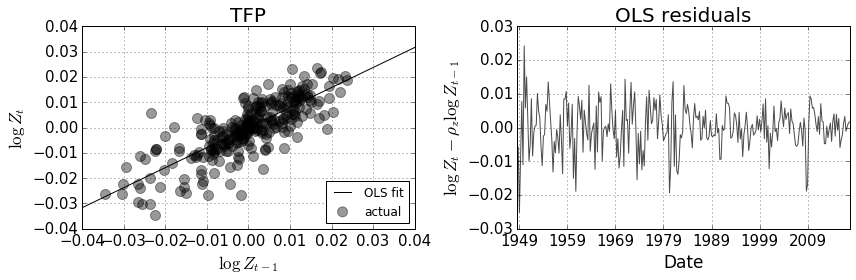

In [7]:
# Estimate the TFP process
X = ts_data['tfp_lag']
Y = ts_data['tfp']

tfp_model = sm.OLS(Y,X)
tfp_results = tfp_model.fit()
print(tfp_results.summary())

rho_z = tfp_results.params['tfp_lag']
sig_z = np.var(tfp_results.resid)**0.5

fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(1,2,1)
ax.scatter(ts_data.tfp_lag,ts_data.tfp,s=100,alpha = 0.4,label='actual',c='k')
ax.plot(np.arange(-1,2),rho_z*np.arange(-1,2),'k',label='OLS fit')
ax.set_xlim([-0.04,0.04])
ax.set_ylim([-0.04,0.04])
ax.set_title('TFP',fontsize=20)
ax.set_xlabel('$\\mathrm{log\,}Z_{t-1}$',fontsize=17)
ax.set_ylabel('$\\mathrm{log\,}Z_t$',fontsize=17)
ax.grid()
ax.legend(loc='lower right',scatterpoints=1)

ax = fig.add_subplot(1,2,2)
ax.plot_date(ts_data.index,tfp_results.resid,'-k',alpha = 0.7,label='actual')
ax.set_title('OLS residuals',fontsize=20)
ax.set_xlabel('Date',fontsize=17)
ax.set_ylabel('$\\mathrm{log\,}Z_t - \\rho_z \\mathrm{log\,}Z_{t-1}$',fontsize=17)
ax.grid()

fig.tight_layout()

print()
print('TFP correlation of autocorrelation:  ',round(rho_z,5))
print('TFP shock standard deviation:        ',round(sig_z,5))

                            OLS Regression Results                            
Dep. Variable:             government   R-squared:                       0.797
Model:                            OLS   Adj. R-squared:                  0.796
Method:                 Least Squares   F-statistic:                     1085.
Date:                Tue, 06 Feb 2018   Prob (F-statistic):           8.61e-98
Time:                        16:34:53   Log-Likelihood:                 790.55
No. Observations:                 278   AIC:                            -1579.
Df Residuals:                     277   BIC:                            -1575.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
government_lag     0.8930      0.027     32.

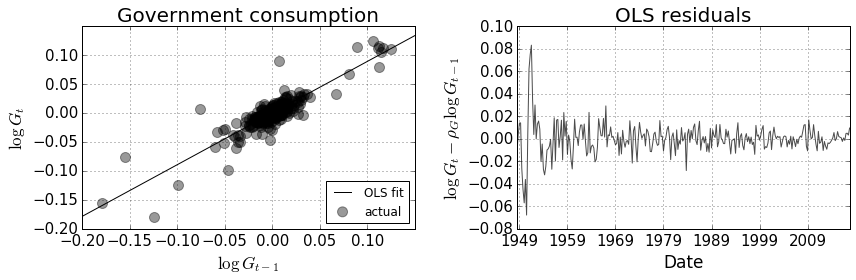

In [8]:
# Estimate the government consumption process
X = ts_data['government_lag']
Y = ts_data['government']

government_model = sm.OLS(Y,X)
government_results = government_model.fit()
print(government_results.summary())

rho_g = government_results.params['government_lag']
sig_g = np.var(government_results.resid)**0.5

fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(1,2,1)
ax.scatter(ts_data.government_lag,ts_data.government,s=100,alpha = 0.4,label='actual',c='k')
ax.plot(np.arange(-1,2),rho_g*np.arange(-1,2),'k',label='OLS fit')
ax.set_xlim([-0.2,0.15])
ax.set_ylim([-0.2,0.15])
ax.set_title('Government consumption',fontsize=20)
ax.set_xlabel('$\\mathrm{log\,}G_{t-1}$',fontsize=17)
ax.set_ylabel('$\\mathrm{log\,}G_t$',fontsize=17)
ax.grid()
ax.legend(loc='lower right',scatterpoints=1)

ax = fig.add_subplot(1,2,2)
ax.plot_date(ts_data.index,government_results.resid,'-k',alpha = 0.7,label='actual')
ax.set_title('OLS residuals',fontsize=20)
ax.set_xlabel('Date',fontsize=17)
ax.set_ylabel('$\\mathrm{log\,}G_t - \\rho_G \\mathrm{log\,}G_{t-1}$',fontsize=17)
ax.grid()

fig.tight_layout()

print()
print('Government consumption correlation of autocorrelation:  ',round(rho_g,5))
print('Government consumption shock standard deviation:        ',round(sig_g,5))

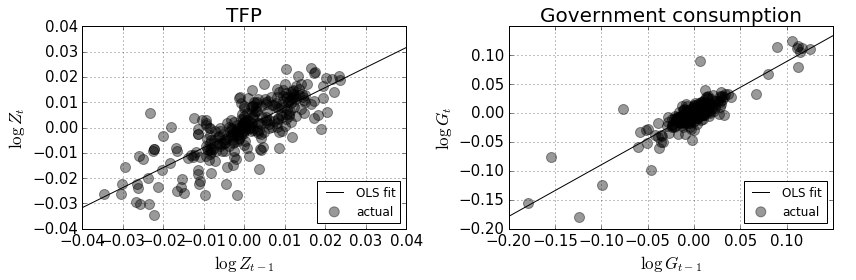

In [9]:
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(1,2,1)
ax.scatter(ts_data.tfp_lag,ts_data.tfp,s=100,alpha = 0.4,label='actual',c='k')
ax.plot(np.arange(-1,2),rho_z*np.arange(-1,2),'k',label='OLS fit')
ax.set_xlim([-0.04,0.04])
ax.set_ylim([-0.04,0.04])
ax.set_title('TFP',fontsize=20)
ax.set_xlabel('$\\mathrm{log\,}Z_{t-1}$',fontsize=17)
ax.set_ylabel('$\\mathrm{log\,}Z_t$',fontsize=17)
ax.grid()
ax.legend(loc='lower right',scatterpoints=1)

ax = fig.add_subplot(1,2,2)
ax.scatter(ts_data.government_lag,ts_data.government,s=100,alpha = 0.4,label='actual',c='k')
ax.plot(np.arange(-1,2),rho_g*np.arange(-1,2),'k',label='OLS fit')
ax.set_xlim([-0.2,0.15])
ax.set_ylim([-0.2,0.15])
ax.set_title('Government consumption',fontsize=20)
ax.set_xlabel('$\\mathrm{log\,}G_{t-1}$',fontsize=17)
ax.set_ylabel('$\\mathrm{log\,}G_t$',fontsize=17)
ax.grid()
ax.legend(loc='lower right',scatterpoints=1)

fig.tight_layout()

### Average share of time spent working

In [10]:
avg_hours  = fp.series('AWHAETP')
h_ss = np.mean(avg_hours.data/7/24)
print('Avg time spent working per week:           ',round(np.mean(avg_hours.data),5))
print('Avg share of workers\' time spent working: ',round(h_ss,5))
print('Avg hours date range:                      ',avg_hours.daterange)
print('Avg hours frequency:                       ',avg_hours.freq)

Avg time spent working per week:            34.33916
Avg share of workers' time spent working:  0.2044
Avg hours date range:                       Range: 2006-03-01 to 2018-01-01
Avg hours frequency:                        Monthly


### Capital-net worth ratio for the US

In [11]:
debt = fp.series('NCBDBIQ027S')
equity = fp.series('MVEONWMVBSNNCB')
equity.data = equity.data*1000
debt = debt.window(['01-01-1952','01-01-2222'])
debt,equity = fp.window_equalize([debt,equity])
k_n_ratio = 1+np.mean(debt.data/equity.data)

print('Capital-net worth ratio: ',round(k_n_ratio,5))
print('debt/equity date range   ',debt.daterange)
print('debt/equity frequency:   ',debt.freq)

Capital-net worth ratio:  1.28781
debt/equity date range    Range: 1952-01-01 to 2017-07-01
debt/equity frequency:    Quarterly


### Interest and inflation data

In [12]:
r_3mo = fp.series('TB3MS')
pce_deflator_monthly = fp.series('PCEPI')
r_3mo_cd = fp.series('IR3TCD01USM156N')
m2_minus_m1 = fp.series('NOM1M2')
checkables = fp.series('TCDSL')

r_3mo,pce_deflator_monthly,r_3mo_cd,m2_minus_m1,checkables = fp.window_equalize([r_3mo,pce_deflator_monthly,r_3mo_cd,m2_minus_m1,checkables])

rn_ss = np.mean(r_3mo.data)/100/4+1
T = len(pce_deflator_monthly.data)-1
pi_ss = ((pce_deflator_monthly.data[-1]/pce_deflator_monthly.data[0])**(1/T)-1)*3+1

m2_minus_m1,checkables,r_3mo_cd = fp.window_equalize([m2_minus_m1,checkables,r_3mo_cd])
int_noint_ratio = m2_minus_m1.data/(m2_minus_m1.data+checkables.data)
rd_ss = np.mean((1+(int_noint_ratio*r_3mo_cd.data+ (1-int_noint_ratio))/100)**0.25)

print('Average (annual) pce deflator inflation rate: ',round(pi_ss**4,5))
print('Average (annual) nominal 3mo bond rate:       ',round(rn_ss**4,5))
print('Average (annual) deposit rate:                ',round((np.mean(rd_ss)**4),5))
print('Interest and inflation date range:            ',r_3mo.daterange)
print('Interest and inflation frequency:             ',r_3mo.freq)

Average (annual) pce deflator inflation rate:  1.03455
Average (annual) nominal 3mo bond rate:        1.04859
Average (annual) deposit rate:                 1.04463
Interest and inflation date range:             Range: 1964-06-01 to 2017-11-01
Interest and inflation frequency:              Monthly


In [13]:
r_3mo = fp.series('TB3MS')
pce_deflator_monthly = fp.series('PCEPI')
r_3mo_cd = fp.series('IR3TCD01USM156N')
m2_minus_m1 = fp.series('NOM1M2')
checkables = fp.series('TCDSL')

r_3mo = r_3mo.window(['01-01-1998','01-01-2222'])

r_3mo,pce_deflator_monthly,r_3mo_cd,m2_minus_m1,checkables = fp.window_equalize([r_3mo,pce_deflator_monthly,r_3mo_cd,m2_minus_m1,checkables])
T = len(pce_deflator_monthly.data)-1

### Excess reserve-deposit ratio

In [14]:
excess_reserves = fp.series('EXCRESNS')
m2_minus_m1 = fp.series('NOM1M2')
checkables = fp.series('TCDSL')

excess_reserves = excess_reserves.window(['01-01-1800','08-01-2008'])
excess_reserves,m2_minus_m1,checkables = fp.window_equalize([excess_reserves,m2_minus_m1,checkables])
total_deposits = checkables.data + m2_minus_m1.data

ex_res_dep_ratio = np.mean(excess_reserves.data/total_deposits)

print('average excess reserve-deposit ratio: ',round(ex_res_dep_ratio,5))
print('excess reserves date range:           ',excess_reserves.daterange)
print('excess reserves frequency:            ',excess_reserves.freq)

average excess reserve-deposit ratio:  0.00051
excess reserves date range:            Range: 1959-01-01 to 2008-08-01
excess reserves frequency:             Monthly


## Calibration and steady state computation

Compute the steady state and calibrate the values of parameters implied by the empirical values collected above. The process goes like this.

\begin{align}
\Pi & = \text{average $\Pi$}\\
H & = \text{average $H$}\\
R^n & = \text{average $R^n$}\\
R^D & = \text{average $R^D$ (deposit rate)}\\
R & = \frac{R^n}{\Pi}
\end{align}

Calibrate $\beta$:

\begin{align}
\beta = \frac{1}{R}
\end{align}

Compute some steady state values directly.

\begin{align}
Q & = 1\\
\bar{Q} & = Q\\
\tilde{P} & = \left( \frac{1-\theta\Pi^{-1+\epsilon}}{1-\theta} \right)^{1/(1-\epsilon)}\\
S & = \frac{(1-\theta)\tilde{P}^{-\epsilon}}{1-\theta\Pi^\epsilon}\\
X & = \left(\frac{1-\theta\beta\Pi^{\epsilon-1}}{1-\theta\beta\Pi^\epsilon}\right)\left(\frac{\epsilon}{\epsilon-1}\right)\tilde{P}^{-1}\\
R^K & = \frac{\alpha \delta S}{X\cdot(\text{average investment to GDP ratio})} + 1 - \delta\\
K & = \left(\frac{\alpha H^{(1-\alpha)\Omega}}{X(R^K + \delta - 1)} \right)^{1/(1-\alpha)}\\
I & = \delta K\\
Y & = K^\alpha H^{(1-\alpha)\Omega}\\
Y^f & = \frac{Y}{S}\\
x_1 & = \frac{\tilde{P}^{-1-\epsilon}Y^f}{X(1-\theta\beta \Pi^{\epsilon})}\\
x_2 & = \frac{\epsilon}{\epsilon-1}x_1\\
W & = \frac{(1-\alpha)\Omega Y}{XH}\\
N & = \frac{K}{\text{average capital to net worth ratio}}\\
\frac{B}{P} & = QK - N\\
\end{align}

Calibrate steady state government consumption:

\begin{align}
\bar{G} & = Y^f \cdot (\text{average government consumption to GDP ratio})
\end{align}

Solve the following system numerically for $\Gamma$, $\Gamma'$, $\Upsilon$, $\Upsilon'$, $\tilde{Z}$, $\sigma_{\omega}$, $\bar{\omega}$, $\bar{R}$, and $\mu$:

\begin{align}
\Gamma & = \frac{1}{2} \left[ 1 + \text{erf}\left( \frac{\tilde{Z} - \sigma_{\omega}}{\sqrt{2}} \right) \right] + \bar{\omega}\frac{1}{2} \left[ 1 - \text{erf}\left( \frac{\tilde{Z}}{\sqrt{2}} \right) \right]\\
\Gamma' & = \frac{1}{2} \left[ 1 - \text{erf}\left( \frac{\tilde{Z}}{\sqrt{2}} \right) \right]\\
\Upsilon & = \frac{1}{2} \left[ 1 + \text{erf}\left( \frac{\tilde{Z} - \sigma_{\omega}}{\sqrt{2}} \right) \right]\\
\Upsilon' & = \frac{1}{\sigma_{\omega} \sqrt{2 \Pi}} \exp\left\{  -\frac{\tilde{Z}^2}{2} \right\}\\
\tilde{Z} & = \frac{\log \bar{\omega} + \sigma_{\omega}^2/2 }{\sigma_{\omega}}\\
\bar{\omega} & = \frac{\bar{R} (QK - N)}{R^KQK\Pi}\\
0 & = \left( 1 - \Gamma \right) R^K - \frac{\Gamma'}{\Pi} \frac{\bar{R} N}{Q K} + \frac{\Gamma'}{\Gamma'-\mu\Upsilon'}\left[(\Gamma'-\mu\Upsilon')\frac{\bar{R}N}{\Pi Q K} + (\Gamma-\mu\Upsilon)R^K-  \frac{(\Gamma - \mu\Upsilon)R^K(1+\pi)QK}{QK - N} \right]\\
\frac{R^D-\rho}{1-\rho} & = \left(\frac{(1-\Gamma)(\Gamma'-\mu \Upsilon')}{\Gamma'} + \Gamma - \mu \Upsilon\right)R^K \Pi\\
F(\bar{\omega}|\sigma_{\omega}^2) & = \text{average default rate}
\end{align}

Then calibrate $\gamma$:

\begin{align}
\gamma & = \frac{N - (1-\alpha)(1-\Omega)K^{\alpha}H^{(1-\alpha)\Omega}/X}{[1-\Gamma]R^KQK}
\end{align}

Compute more steady state quantities directly:

\begin{align}
C^e & = (1-\gamma)(1-\Gamma)R^KQK\\
C & = Y^f - C^e-I-G - \mu\Upsilon R^K QK\\
\lambda & = C^{-1}\\
\chi & = \left(\frac{R^d - \rho}{1-\rho}\right)\frac{B}{P}\\
\end{align}

Compute steady state excess reserves based on observed historic ratio of excess reserves to deposits:

\begin{align}
\frac{M^{ex}}{P} & = \frac{\text{average excess reserve to deposit ratio}}{D}
\end{align}

Compute more steady state quantities directly:

\begin{align}
\bar{\Phi} & = \left(\chi - \frac{R^d - \rho}{1-\rho}\frac{B}{P} + \frac{1-R^d}{1-\rho}\frac{M^{ex}}{P}\right)/\Pi\\
\tilde{u}\left(\bar{\Phi}\right) & = -\exp(-\xi_{\Phi}\bar{\Phi})\\
\tilde{u}'\left(\bar{\Phi}\right) & = \xi_{\Phi}\exp(-\xi_{\Phi}\bar{\Phi})\\
\tilde{\lambda} & = \frac{\Gamma'}{(\Gamma'-\mu\Upsilon')\tilde{u}'\left(\bar{\Phi}\right)}
\end{align}

Calibrate penalty function parameter

\begin{align}
\mu_x = \frac{R^d-1}{1-\rho}\frac{\tilde{u}'\left(\bar{\Phi}\right)}{\Pi}\frac{M^{ex}}{P}
\end{align}

Calibrate preference parameter on deposits

\begin{align}
\zeta_d = \left(\frac{QK-N+M^{ex}/P}{1-\rho}\right)C\left(\frac{R^n-R^d}{R^n}\right)
\end{align}

Calibrate preference parameter on leisure

\begin{align}
\zeta_h = WC^{-1}(1-H)
\end{align}

In [15]:
# Assumed parameters
rho_v = 0
rho_sw = 0.85
rho_ss = 0.9
sig_v = .49/400
sig_sw = 0.028
sig_ss = 1**0.5
eta_s = 1
sig_s = 0.1190
alpha = 0.35
omega = 0.64/(1-alpha)
theta = 0.8
epsilon = 5
psi = 0.25
default_rate = .03/4
req_res_ratio = 0.01
rho_r = 0.9
phi_pi = 1.5
phi_y = 0.5/4
xi_phi = 20

In [16]:
def calibrate_rab_model(pi_ss,h_ss,rn_ss,rd_ss,rho_v,rho_sw,rho_ss,sig_v,sig_sw,sig_ss,eta_s,sig_s,alpha,omega,theta,epsilon,psi,default_rate,req_res_ratio,rho_r,phi_pi,phi_y,xi_phi):
    
    '''Function for calibrating the risk-averse banking model'''
    
    # Steady states / calibration
    pi = pi_ss
    h = h_ss
    rn = rn_ss
    rd = rd_ss
    r = rn/pi

    # Calibrate beta
    beta = 1/r
    q = 1
    qbar = q
    ptil = ((1-theta*pi**(-1+epsilon))/(1-theta))**(1/(1-epsilon))
    s = (1-theta)*ptil**-epsilon/(1-theta*pi**epsilon)
    x = (1-theta*beta*pi**(epsilon-1))/(1-theta*beta*pi**epsilon)/ptil*epsilon/(epsilon-1)

    rk = (alpha*delta*s)/x/i_yf_ratio+1-delta
    k = (alpha*h**((1-alpha)*omega)/x/(rk+delta-1))**(1/(1-alpha))
    i = delta*k
    y = k**alpha*h**((1-alpha)*omega)
    yf = y/s
    x1 = ptil**(-1-epsilon)*yf/x/(1 - theta*beta*pi**epsilon)
    x2 = epsilon/(epsilon-1)*x1

    w = (1-alpha)*omega*y/h/x
    n = k/k_n_ratio
    b = q*k-n

    # Calibrate steady state government consumption
    g_ss = yf*g_yf_ratio

    # Calibrate rbar and solve for steady state wbar, sigmaw, rbar
    def fun_to_calibrate_financial_block(x):
        
        wbar,sigmaw,rbar,mu = x

        ztil = (np.log(wbar) + sigmaw**2/2)/sigmaw
        gam = 0.5*(1 + erf((ztil-sigmaw)/2**.5)) + wbar * 0.5*(1-erf(ztil/2**.5))
        gamp = 0.5*(1 - erf(ztil/2**.5))
        ups = 0.5*(1+erf((ztil-sigmaw)/2**.5))
        upsp = 1/(sigmaw*(2*np.pi)**.5)*np.exp(-(ztil)**2/2)
        
        retval = np.zeros(4)
        retval[0] = lognorm.cdf(x = wbar, s=sigmaw, scale = np.exp(-sigmaw**2/2)) - default_rate
        retval[1] = rbar*(q*k-n)/rk/q/k/pi - wbar
        retval[2] = (1-gam)*rk - gamp*rbar*n/pi/q/k+gamp/(gamp-mu*upsp)*(  (gamp-mu*upsp)*rbar*n/pi/q/k + (gam-mu*ups)*rk - (gam-mu*ups)*rk*q*k/(q*k-n)  )
        retval[3] = (1-req_res_ratio)*(gam-mu*ups)*rk*pi*q*k/(q*k-n)+req_res_ratio - rd

        return retval

    wbar,sigmaw,rbar,mu = fsolve(fun_to_calibrate_financial_block,[0.5,0.27,1.015,0.3])

    ztil = (np.log(wbar) + sigmaw**2/2)/sigmaw
    gam = 0.5*(1 + erf((ztil-sigmaw)/2**.5)) + wbar * 0.5*(1-erf(ztil/2**.5))
    gamp = 0.5*(1 - erf(ztil/2**.5))
    ups = 0.5*(1+erf((ztil-sigmaw)/2**.5))
    upsp = 1/(sigmaw*(2*np.pi)**.5)*np.exp(-(ztil)**2/2)

    # Calibrate gamma
    gamma = (n-(1-alpha)*(1-omega)*k**alpha*h**((1-alpha)*omega)/x)/(1-gam)/rk/q/k
    
    ce = (1-gamma)*(1-gam)*rk*q*k
    c = yf - ce-i-g_ss - mu*ups*rk*q*k
    lam = c**-1
    chi = (rd - req_res_ratio)/(1-req_res_ratio)*b
    mex = b*ex_res_dep_ratio/(1-req_res_ratio-ex_res_dep_ratio)
    cap_phi = (chi - (rd - req_res_ratio)/(1-req_res_ratio)*b + (1-rd)/(1-req_res_ratio)*mex)/pi
    util = -np.exp(-xi_phi*cap_phi)
    utilp = xi_phi*np.exp(-xi_phi*cap_phi)
    lamtil = gamp/(gamp-mu*upsp)/(xi_phi*np.exp(-xi_phi*cap_phi))

    # Calibrate penalty function parameter
    mux = (rd-1)/(1-req_res_ratio)/pi*utilp*mex

    # Calibrate preference parameter on deposits
    zetad = ((q*k-n+mex)/(1-req_res_ratio))*c**-1*(rn-rd)/rn

    # Calibrate preference parameter on leisure
    zetah = w*c**-1*(1-h)


    # Parameters
    parameters = pd.Series()
    parameters['delta'] = delta
    parameters['alpha'] = alpha
    parameters['h_ss'] = h_ss
    parameters['pi_ss'] = pi_ss
    parameters['beta'] = beta
    parameters['i_yf_ratio'] = i_yf_ratio
    parameters['g_yf_ratio'] = g_yf_ratio
    parameters['k_n_ratio'] = k_n_ratio
    parameters['rd_ss'] = rd_ss
    parameters['theta'] = theta
    parameters['epsilon'] = epsilon
    parameters['omega'] = omega
    parameters['psi'] = psi
    parameters['default_rate'] = default_rate
    parameters['g_ss'] = g_ss
    parameters['req_res_ratio'] = req_res_ratio
    parameters['mu'] = mu
    parameters['gamma'] = gamma
    parameters['xi_phi'] = xi_phi
    parameters['mux'] = mux
    parameters['zetad'] = zetad
    parameters['zetah'] = zetah
    parameters['i_ss'] = i
    parameters['k_ss'] = k
    parameters['yf_ss'] = yf
    parameters['rho_r'] = rho_r
    parameters['phi_pi'] = phi_pi
    parameters['phi_y'] = phi_y
    parameters['sigmaw_ss'] = sigmaw
    parameters['rho_z'] = rho_z
    parameters['rho_g'] = rho_g
    parameters['rho_v'] = rho_v
    parameters['rho_sw'] = rho_sw
    parameters['rho_ss'] = rho_ss
    parameters['sig_z'] = sig_z
    parameters['sig_g'] = sig_g
    parameters['sig_v'] = sig_v
    parameters['sig_s'] = sig_s
    parameters['eta_s'] = eta_s
    parameters['sig_sw'] = sig_sw
    parameters['sig_ss'] = sig_ss

    # Steady state values
    computed_ss = pd.Series()
    computed_ss['pi'] = pi
    computed_ss['h'] = h
    computed_ss['rbar'] = rbar
    computed_ss['rd'] = rd
    computed_ss['q'] = q
    computed_ss['r'] = r
    computed_ss['rn'] = rn
    computed_ss['qbar'] = qbar
    computed_ss['ptil'] = ptil
    computed_ss['s'] = s
    computed_ss['x'] = x
    computed_ss['rk'] = rk
    computed_ss['k'] = k
    computed_ss['i'] = i
    computed_ss['y'] = y
    computed_ss['yf'] = yf
    computed_ss['x1'] = x1
    computed_ss['x2'] = x2
    computed_ss['w'] = w
    computed_ss['n'] = n
    computed_ss['b'] = b
    computed_ss['wbar'] = wbar
    computed_ss['sigmaw'] = sigmaw
    computed_ss['ztil'] = ztil
    computed_ss['gam'] = gam
    computed_ss['gamp'] = gamp
    computed_ss['ups'] = ups
    computed_ss['upsp'] = upsp
    computed_ss['ce'] = ce
    computed_ss['c'] = c
    computed_ss['lam'] = lam
    computed_ss['chi'] = chi
    computed_ss['mex'] = mex
    computed_ss['cap_phi'] = cap_phi
    computed_ss['lamtil'] = lamtil

    # Exogenous vars
    computed_ss['z'] = 0
    computed_ss['g'] = g_ss
    computed_ss['v'] = 0
    computed_ss['sigmas'] = sig_ss
    
    return parameters,computed_ss

In [17]:
def calibrate_bgg_model(pi_ss,h_ss,rn_ss,rd_ss,rho_v,rho_sw,rho_ss,sig_v,sig_sw,sig_ss,eta_s,sig_s,alpha,omega,theta,epsilon,psi,default_rate,req_res_ratio,rho_r,phi_pi,phi_y):
    
    '''Function for calibrating the BGG model'''
    
    # Steady states / calibration
    pi = pi_ss*0+1
    h = h_ss
    rn = rn_ss
    rd = rd_ss
    r = rn/pi

    # Calibrate beta
    beta = 1/r
    q = 1
    qbar = q
    ptil = ((1-theta*pi**(-1+epsilon))/(1-theta))**(1/(1-epsilon))
    s = (1-theta)*ptil**-epsilon/(1-theta*pi**epsilon)
    x = (1-theta*beta*pi**(epsilon-1))/(1-theta*beta*pi**epsilon)/ptil*epsilon/(epsilon-1)

    rk = (alpha*delta*s)/x/i_yf_ratio+1-delta
    k = (alpha*h**((1-alpha)*omega)/x/(rk+delta-1))**(1/(1-alpha))
    i = delta*k
    y = k**alpha*h**((1-alpha)*omega)
    yf = y/s
    x1 = ptil**(-1-epsilon)*yf/x/(1 - theta*beta*pi**epsilon)
    x2 = epsilon/(epsilon-1)*x1

    w = (1-alpha)*omega*y/h/x
    n = k/k_n_ratio
    b = q*k-n

    # Calibrate steady state government consumption
    g_ss = yf*g_yf_ratio

    # Calibrate rbar and solve for steady state wbar, sigmaw, rbar
    def fun_to_calibrate_financial_block(x):
        
        wbar,sigmaw,rbar,mu = x

        ztil = (np.log(wbar) + sigmaw**2/2)/sigmaw
        gam = 0.5*(1 + erf((ztil-sigmaw)/2**.5)) + wbar * 0.5*(1-erf(ztil/2**.5))
        gamp = 0.5*(1 - erf(ztil/2**.5))
        ups = 0.5*(1+erf((ztil-sigmaw)/2**.5))
        upsp = 1/(sigmaw*(2*np.pi)**.5)*np.exp(-(ztil)**2/2)
        
        retval = np.zeros(4)
        retval[0] = lognorm.cdf(x = wbar, s=sigmaw, scale = np.exp(-sigmaw**2/2)) - default_rate
        retval[1] = rbar*(q*k-n)/rk/q/k/pi - wbar
        retval[2] = (1-gam)*rk - gamp*rbar*n/pi/q/k+gamp/(gamp-mu*upsp)*(  (gamp-mu*upsp)*rbar*n/pi/q/k + (gam-mu*ups)*rk - (gam-mu*ups)*rk*q*k/(q*k-n)  )
        retval[3] = (1-req_res_ratio)*(gam-mu*ups)*rk*pi*q*k/(q*k-n)+req_res_ratio - rd

        return retval

    wbar,sigmaw,rbar,mu = fsolve(fun_to_calibrate_financial_block,[0.5,0.27,1.015,0.3])
    
    ztil = (np.log(wbar) + sigmaw**2/2)/sigmaw
    gam = 0.5*(1 + erf((ztil-sigmaw)/2**.5)) + wbar * 0.5*(1-erf(ztil/2**.5))
    gamp = 0.5*(1 - erf(ztil/2**.5))
    ups = 0.5*(1+erf((ztil-sigmaw)/2**.5))
    upsp = 1/(sigmaw*(2*np.pi)**.5)*np.exp(-(ztil)**2/2)

    # Calibrate gamma
    gamma = (n-(1-alpha)*(1-omega)*k**alpha*h**((1-alpha)*omega)/x)/(1-gam)/rk/q/k

    ce = (1-gamma)*(1-gam)*rk*q*k
    c = yf - ce-i-g_ss - mu*ups*rk*q*k
    lam = c**-1
    chi = (rd - req_res_ratio)/(1-req_res_ratio)*b
    mex = b*ex_res_dep_ratio/(1-req_res_ratio-ex_res_dep_ratio)
    cap_phi = (chi - (rd - req_res_ratio)/(1-req_res_ratio)*b + (1-rd)/(1-req_res_ratio)*mex)/pi
    util = cap_phi
    utilp = 1
    lamtil = gamp/(gamp-mu*upsp)/utilp

    # Calibrate penalty function parameter
    mux = (rd-1)/(1-req_res_ratio)/pi*utilp*mex

    # Calibrate preference parameter on deposits
    zetad = ((q*k-n+mex)/(1-req_res_ratio))*c**-1*(rn-rd)/rn

    # Calibrate preference parameter on leisure
    zetah = w*c**-1*(1-h)


    # Parameters
    parameters = pd.Series()
    parameters['delta'] = delta
    parameters['alpha'] = alpha
    parameters['h_ss'] = h_ss
    parameters['pi_ss'] = pi_ss
    parameters['beta'] = beta
    parameters['i_yf_ratio'] = i_yf_ratio
    parameters['g_yf_ratio'] = g_yf_ratio
    parameters['k_n_ratio'] = k_n_ratio
    parameters['rd_ss'] = rd_ss
    parameters['theta'] = theta
    parameters['epsilon'] = epsilon
    parameters['omega'] = omega
    parameters['psi'] = psi
    parameters['default_rate'] = default_rate
    parameters['g_ss'] = g_ss
    parameters['req_res_ratio'] = req_res_ratio
    parameters['mu'] = mu
    parameters['gamma'] = gamma
    parameters['mux'] = mux
    parameters['zetad'] = zetad
    parameters['zetah'] = zetah
    parameters['i_ss'] = i
    parameters['k_ss'] = k
    parameters['yf_ss'] = yf
    parameters['rho_r'] = rho_r
    parameters['phi_pi'] = phi_pi
    parameters['phi_y'] = phi_y
    parameters['sigmaw_ss'] = sigmaw
    parameters['rho_z'] = rho_z
    parameters['rho_g'] = rho_g
    parameters['rho_v'] = rho_v
    parameters['rho_sw'] = rho_sw
    parameters['rho_ss'] = rho_ss
    parameters['sig_z'] = sig_z
    parameters['sig_g'] = sig_g
    parameters['sig_v'] = sig_v
    parameters['sig_s'] = sig_s
    parameters['eta_s'] = eta_s
    parameters['sig_sw'] = sig_sw
    parameters['sig_ss'] = sig_ss

    # Steady state values
    computed_ss = pd.Series()
    computed_ss['pi'] = pi
    computed_ss['h'] = h
    computed_ss['rbar'] = rbar
    computed_ss['rd'] = rd
    computed_ss['q'] = q
    computed_ss['r'] = r
    computed_ss['rn'] = rn
    computed_ss['qbar'] = qbar
    computed_ss['ptil'] = ptil
    computed_ss['s'] = s
    computed_ss['x'] = x
    computed_ss['rk'] = rk
    computed_ss['k'] = k
    computed_ss['i'] = i
    computed_ss['y'] = y
    computed_ss['yf'] = yf
    computed_ss['x1'] = x1
    computed_ss['x2'] = x2
    computed_ss['w'] = w
    computed_ss['n'] = n
    computed_ss['b'] = b
    computed_ss['wbar'] = wbar
    computed_ss['sigmaw'] = sigmaw
    computed_ss['ztil'] = ztil
    computed_ss['gam'] = gam
    computed_ss['gamp'] = gamp
    computed_ss['ups'] = ups
    computed_ss['upsp'] = upsp
    computed_ss['ce'] = ce
    computed_ss['c'] = c
    computed_ss['lam'] = lam
    computed_ss['chi'] = chi
    computed_ss['mex'] = mex
    computed_ss['cap_phi'] = cap_phi
    computed_ss['lamtil'] = lamtil

    # Exogenous vars
    computed_ss['z'] = 0
    computed_ss['g'] = g_ss
    computed_ss['v'] = 0
    computed_ss['sigmas'] = sig_ss
    
    return parameters,computed_ss

In [18]:
# Compute steady state and calibrate
parameters,computed_ss = calibrate_rab_model(pi_ss,h_ss,rn_ss,rd_ss,rho_v,rho_sw,rho_ss,sig_v,sig_sw,sig_ss,eta_s,sig_s,alpha,omega,theta,epsilon,psi,default_rate,req_res_ratio,rho_r,phi_pi,phi_y,xi_phi)
print(parameters)
print(computed_ss)

delta             0.027253
alpha             0.350000
h_ss              0.204400
pi_ss             1.008529
beta              0.996636
i_yf_ratio        0.169619
g_yf_ratio        0.204574
k_n_ratio         1.287812
rd_ss             1.010976
theta             0.800000
epsilon           5.000000
omega             0.984615
psi               0.250000
default_rate      0.007500
g_ss              0.113872
req_res_ratio     0.010000
mu                0.489195
gamma             0.977560
xi_phi           20.000000
mux               0.000087
zetad             0.002604
zetah             3.905350
i_ss              0.094415
k_ss              3.464388
yf_ss             0.556630
rho_r             0.900000
phi_pi            1.500000
phi_y             0.125000
sigmaw_ss         0.556745
rho_z             0.791761
rho_g             0.892987
rho_v             0.000000
rho_sw            0.850000
rho_ss            0.900000
sig_z             0.006717
sig_g             0.014085
sig_v             0.001225
s

### Solution and simulation

In [19]:
# Setup for running dynare++
centralize=True
order= 3
useExisting=True
sim= 100
per = 200

# Shocks, endogenous variables, and the covariance matrix
shockNames = ['e_z', 'e_g', 'e_v', 'e_sw', 'e_ss']
varNames = ['y', 'yf', 'c', 'h', 's', 'lam', 'r', 'rn', 'x1', 'x2', 'ptil', 'pi', 'w', 'x', 'k', 'i', 'rk', 'q', 'qbar', 'wbar', 'n', 'ztil', 'gam', 'gamp', 'ups', 'upsp', 'lamtil', 'ce', 'z', 'g', 'v', 'sigmaw', 'sigmas', 'chi', 'b', 'mex', 'rd', 'cap_phi', 'rbar']
covMat = [[sig_z**2,0,0,0,0],[0,sig_g**2,0,0,0],[0,0,sig_v**2,0,0],[0,0,0,sig_sw**2,0],[0,0,0,0,sig_ss**2]]

#### Risk-averse banking model

In [20]:
# Equilibrium conditions of the RAB model
equations_rab = ['y = exp(z)*k^alpha*h^((1-alpha)*omega)',
                 'yf = y / s',
                 'k = (1/(1-psi) *(i(-1)/k(-1))^(1-psi) *delta^psi - psi/(1-psi)*delta)*k(-1) + (1-delta)*k(-1)',
                 'q = (i/k(-1))^psi*delta^-psi',
                 'rk = (alpha*y/x/k+(1-delta)*qbar)/(q(-1))',
                 '0 = q*(1/(1-psi) *(i/k)^(1-psi) *delta^psi - psi/(1-psi)*delta) - i/k - qbar + q',
                 '(1-alpha)*omega *y / h = x * w',
                 'n = gamma*(1-gam(-1))*rk(-1)*q(-2)*k(-1) + (1-alpha)*(1-omega)*exp(z(-1))*k(-1)^alpha*h^((1-alpha)*omega)/x(-1)',
                 'lam = c^-1',
                 'ce = (1-gamma)*(1-gam)*rk*q(-1)*k',
                 'yf = c + ce +i+mu*ups*rk*q(-1)*k+ exp(g)',
                 'lam = beta*r*lam(1)',
                 'w*c^-1 = zetah*(1-h)^-1',
                 'rn = r*pi(1)',
                 'chi = (gam - mu * ups)*rk*pi*q(-1)*k',
                 'b = q*k(1)-n(1)',
                 '((q*k(1) - n(1) + mex)/(1-req_res_ratio)) = zetad*c*rn/(rn-rd)',
                 '(mex/pi(1)*(1-rd)/(1-req_res_ratio)*xi_phi*exp(-xi_phi*cap_phi(1)) + mux) = 0',
                 'cap_phi = (chi - (rd(-1) - req_res_ratio)/(1-req_res_ratio)*b(-1) + (1-rd(-1))/(1-req_res_ratio)*mex(-1))/pi',
                 '1 = theta * pi^(-1+epsilon) + (1-theta)*ptil^(1-epsilon)',
                 'x1 = ptil^(-1-epsilon)*yf/x + theta*beta*(lam(1)/lam*pi(1)^(epsilon)*(ptil/ptil(1))^(-1-epsilon)*x1(1))',
                 'x2 = ptil^(-epsilon)*yf + theta*beta*(lam(1)/lam*pi(1)^(epsilon-1)*(ptil/ptil(1))^(-epsilon)*x2(1))',
                 'epsilon/(epsilon-1)*x1 = x2',
                 's = (1-theta)*ptil^(-epsilon) + theta*pi^(epsilon)*s(-1)',
                 'ztil = (log(wbar) + sigmaw^2/2)/sigmaw',
                 'gam = 0.5*(1 + erf((ztil-sigmaw)/2^.5)) + wbar * 0.5*(1-erf(ztil/2^.5))',
                 'gamp = 0.5*(1 - erf(ztil/2^.5))',
                 'ups = 0.5*(1+erf((ztil-sigmaw)/2^.5))',
                 'upsp = 1/(sigmaw*(2*3.14159265358979)^.5)*exp(-(ztil)^2/2)',
                 '(1-gam(1))*rk(1) - gamp(1)*rbar*n(1)/q/k(1)/pi(1) + lamtil * ( xi_phi*exp(-xi_phi*cap_phi(1))*((gamp(1)-mu*upsp(1))*rbar*n(1)/q/k(1)/pi(1) + (gam(1) - mu*ups(1))*rk(1) - (rd-req_res_ratio)/pi(1)/(1-req_res_ratio) )) = 0',
                 'gamp(1)/pi(1) - lamtil*xi_phi*exp(-xi_phi*cap_phi(1))*(gamp(1) - mu*upsp(1))/pi(1) = 0',
                 'exp(-xi_phi*cap_phi(1)) = exp(-xi_phi*((1-rd)*mex/(1-req_res_ratio)/pi(1)))',
                 'wbar*pi*rk*q(-1)*k = rbar(-1)*(q(-1)*k - n)',
                 'log(rn) = (1-rho_r)*log(pi_ss/beta) + rho_r * log(rn(-1))+ phi_pi*log(pi) - phi_pi*log(pi_ss) + phi_y*log(yf) - phi_y*log(yf_ss) + v',
                 'z = rho_z * z(-1) + e_z',
                 'g = (1-rho_g)*log(g_ss) + (1-rho_g)*g_ss + rho_g *g(-1) + e_g',
                 'v = rho_v * v(-1) + e_v',
                 'log(sigmaw) = (1-rho_sw)*log(sigmaw_ss) + rho_sw*log(sigmaw(-1)) + exp(sigmas) * e_sw',
                 'sigmas = (1-rho_ss)*sig_s + rho_ss*sigmas(-1) + eta_s*e_ss']

In [21]:
parameters_rab_xi_phi_1,computed_ss_rab_xi_phi_1 = calibrate_rab_model(pi_ss,h_ss,rn_ss,rd_ss,rho_v,rho_sw,rho_ss,sig_v,sig_sw,sig_ss,eta_s,sig_s,alpha,omega,theta,epsilon,psi,default_rate,req_res_ratio,rho_r,phi_pi,phi_y,xi_phi=1)
steadyStates_rab_xi_phi_1 = []
for name in varNames:
    steadyStates_rab_xi_phi_1.append(name+' = '+str(computed_ss_rab_xi_phi_1[name]))
filename = 'model_rab_xi_phi_1.mod'
model_rab_xi_phi_1 = dh.model(parameters_rab_xi_phi_1,
                    shockNames,
                    varNames,
                    equations_rab,
                    steadyStates_rab_xi_phi_1,
                    covMat,
                    order,
                    filename)


parameters_rab_xi_phi_10,computed_ss_rab_xi_phi_10 = calibrate_rab_model(pi_ss,h_ss,rn_ss,rd_ss,rho_v,rho_sw,rho_ss,sig_v,sig_sw,sig_ss,eta_s,sig_s,alpha,omega,theta,epsilon,psi,default_rate,req_res_ratio,rho_r,phi_pi,phi_y,xi_phi=10)
steadyStates_rab_xi_phi_10 = []
for name in varNames:
    steadyStates_rab_xi_phi_10.append(name+' = '+str(computed_ss_rab_xi_phi_10[name]))
filename = 'model_rab_xi_phi_10.mod'
model_rab_xi_phi_10 = dh.model(parameters_rab_xi_phi_10,
                    shockNames,
                    varNames,
                    equations_rab,
                    steadyStates_rab_xi_phi_10,
                    covMat,
                    order,
                    filename)

parameters_rab_xi_phi_50,computed_ss_rab_xi_phi_50 = calibrate_rab_model(pi_ss,h_ss,rn_ss,rd_ss,rho_v,rho_sw,rho_ss,sig_v,sig_sw,sig_ss,eta_s,sig_s,alpha,omega,theta,epsilon,psi,default_rate,req_res_ratio,rho_r,phi_pi,phi_y,xi_phi=50)
steadyStates_rab_xi_phi_50 = []
for name in varNames:
    steadyStates_rab_xi_phi_50.append(name+' = '+str(computed_ss_rab_xi_phi_50[name]))
filename = 'model_rab_xi_phi_50.mod'
model_rab_xi_phi_50 = dh.model(parameters_rab_xi_phi_50,
                    shockNames,
                    varNames,
                    equations_rab,
                    steadyStates_rab_xi_phi_50,
                    covMat,
                    order,
                    filename)

parameters_rab_xi_phi_20,computed_ss_rab_xi_phi_20 = calibrate_rab_model(pi_ss,h_ss,rn_ss,rd_ss,rho_v,rho_sw,rho_ss,sig_v,sig_sw,sig_ss,eta_s,sig_s,alpha,omega,theta,epsilon,psi,default_rate,req_res_ratio,rho_r,phi_pi,phi_y,xi_phi=20)
steadyStates_rab_xi_phi_20 = []
for name in varNames:
    steadyStates_rab_xi_phi_20.append(name+' = '+str(computed_ss_rab_xi_phi_20[name]))
filename = 'model_rab_xi_phi_20.mod'
model_rab_xi_phi_20 = dh.model(parameters_rab_xi_phi_20,
                    shockNames,
                    varNames,
                    equations_rab,
                    steadyStates_rab_xi_phi_20,
                    covMat,
                    order,
                    filename)

parameters_rab_xi_phi_100,computed_ss_rab_xi_phi_100 = calibrate_rab_model(pi_ss,h_ss,rn_ss,rd_ss,rho_v,rho_sw,rho_ss,sig_v,sig_sw,sig_ss,eta_s,sig_s,alpha,omega,theta,epsilon,psi,default_rate,req_res_ratio,rho_r,phi_pi,phi_y,xi_phi=100)
steadyStates_rab_xi_phi_100 = []
for name in varNames:
    steadyStates_rab_xi_phi_100.append(name+' = '+str(computed_ss_rab_xi_phi_100[name]))
filename = 'model_rab_xi_phi_100.mod'
model_rab_xi_phi_100 = dh.model(parameters_rab_xi_phi_100,
                    shockNames,
                    varNames,
                    equations_rab,
                    steadyStates_rab_xi_phi_100,
                    covMat,
                    order,
                    filename)


model_rab_xi_phi_1.approximate(centralize=centralize,order=order,otherOptions=['--ss-tol','10-16'],sim=sim,per=per,useExisting=useExisting,clock=False)
model_rab_xi_phi_10.approximate(centralize=centralize,order=order,otherOptions=['--ss-tol','10-16'],sim=sim,per=per,useExisting=useExisting,clock=False)
model_rab_xi_phi_20.approximate(centralize=centralize,order=order,otherOptions=['--ss-tol','10-16'],sim=sim,per=per,useExisting=useExisting,clock=False)
model_rab_xi_phi_50.approximate(centralize=centralize,order=order,otherOptions=['--ss-tol','10-16'],sim=sim,per=per,useExisting=useExisting,clock=False)
model_rab_xi_phi_100.approximate(centralize=centralize,order=order,otherOptions=['--ss-tol','10-16'],sim=sim,per=per,useExisting=useExisting,clock=False)

model_rab_xi_phi_1.cleanup()
model_rab_xi_phi_10.cleanup()
model_rab_xi_phi_20.cleanup()
model_rab_xi_phi_50.cleanup()
model_rab_xi_phi_100.cleanup()

#### BGG (risk neutral banking)

In [22]:
# Equilibrium conditions for model with risk neutral banks
equations_bgg = ['y = exp(z)*k^alpha*h^((1-alpha)*omega)',
                 'yf = y / s',
                 'k = (1/(1-psi) *(i(-1)/k(-1))^(1-psi) *delta^psi - psi/(1-psi)*delta)*k(-1) + (1-delta)*k(-1)',
                 'q = (i/k(-1))^psi*delta^-psi',
                 'rk = (alpha*y/x/k+(1-delta)*qbar)/(q(-1))',
                 '0 = q*(1/(1-psi) *(i/k)^(1-psi) *delta^psi - psi/(1-psi)*delta) - i/k - qbar + q',
                 '(1-alpha)*omega *y / h = x * w',
                 'n = gamma*(1-gam(-1))*rk(-1)*q(-2)*k(-1) + (1-alpha)*(1-omega)*exp(z(-1))*k(-1)^alpha*h^((1-alpha)*omega)/x(-1)',
                 'lam = c^-1',
                 'ce = (1-gamma)*(1-gam)*rk*q(-1)*k',
                 'yf = c + ce +i+mu*ups*rk*q(-1)*k+ exp(g)',
                 'lam = beta*r*lam(1)',
                 'w*c^-1 = zetah*(1-h)^-1',
                 'rn = r*pi(1)',
                 'chi = (gam - mu * ups)*rk*pi*q(-1)*k',
                 'b = q*k(1)-n(1)',
                 '((q*k(1) - n(1) + mex)/(1-req_res_ratio)) = zetad*c*rn/(rn-rd)',
                 '(mex/pi(1)*(1-rd)/(1-req_res_ratio)*1 + mux) = 0',
                 'cap_phi = (chi - (rd(-1) - req_res_ratio)/(1-req_res_ratio)*b(-1) + (1-rd(-1))/(1-req_res_ratio)*mex(-1))/pi',
                 '1 = theta * pi^(-1+epsilon) + (1-theta)*ptil^(1-epsilon)',
                 'x1 = ptil^(-1-epsilon)*yf/x + theta*beta*(lam(1)/lam*pi(1)^(epsilon)*(ptil/ptil(1))^(-1-epsilon)*x1(1))',
                 'x2 = ptil^(-epsilon)*yf + theta*beta*(lam(1)/lam*pi(1)^(epsilon-1)*(ptil/ptil(1))^(-epsilon)*x2(1))',
                 'epsilon/(epsilon-1)*x1 = x2',
                 's = (1-theta)*ptil^(-epsilon) + theta*pi^(epsilon)*s(-1)',
                 'ztil = (log(wbar) + sigmaw^2/2)/sigmaw',
                 'gam = 0.5*(1 + erf((ztil-sigmaw)/2^.5)) + wbar * 0.5*(1-erf(ztil/2^.5))',
                 'gamp = 0.5*(1 - erf(ztil/2^.5))',
                 'ups = 0.5*(1+erf((ztil-sigmaw)/2^.5))',
                 'upsp = 1/(sigmaw*(2*3.14159265358979)^.5)*exp(-(ztil)^2/2)',
                 '(1-gam(1))*rk(1) - gamp(1)*rbar*n(1)/q/k(1)/pi(1) + lamtil * ( 1*((gamp(1)-mu*upsp(1))*rbar*n(1)/q/k(1)/pi(1) + (gam(1) - mu*ups(1))*rk(1) - (rd-req_res_ratio)/pi(1)/(1-req_res_ratio) )) = 0',
                 'gamp(1)/pi(1) - lamtil*1*(gamp(1) - mu*upsp(1))/pi(1) = 0',
                 'cap_phi(1) = (1-rd)*mex/(1-req_res_ratio)/pi(1)',
                 'wbar*pi*rk*q(-1)*k = rbar(-1)*(q(-1)*k - n)',
                 'log(rn) = (1-rho_r)*log(pi_ss/beta) + rho_r * log(rn(-1))+ phi_pi*log(pi) - phi_pi*log(pi_ss) + phi_y*log(yf) - phi_y*log(yf_ss) + v',
                 'z = rho_z * z(-1) + e_z',
                 'g = (1-rho_g)*log(g_ss) + (1-rho_g)*g_ss + rho_g *g(-1) + e_g',
                 'v = rho_v * v(-1) + e_v',
                 'log(sigmaw) = (1-rho_sw)*log(sigmaw_ss) + rho_sw*log(sigmaw(-1)) + exp(sigmas) * e_sw',
                 'sigmas = (1-rho_ss)*sig_s + rho_ss*sigmas(-1) + eta_s*e_ss']

In [23]:
filename = 'model_bgg.mod'
parameters_bgg,computed_ss_bgg = calibrate_bgg_model(pi_ss,h_ss,rn_ss,rd_ss,rho_v,rho_sw,rho_ss,sig_v,sig_sw,sig_ss,eta_s,sig_s,alpha,omega,theta,epsilon,psi,default_rate,req_res_ratio,rho_r,phi_pi,phi_y)
steadyStates_bgg = []
for name in varNames:
    steadyStates_bgg.append(name+' = '+str(computed_ss_bgg[name]))
    
model_bgg = dh.model(parameters_bgg,
                    shockNames,
                    varNames,
                    equations_bgg,
                    steadyStates_bgg,
                    covMat,
                    order,
                    filename)


model_bgg.approximate(centralize=centralize,order=order,otherOptions=['--ss-tol','10-16'],sim=sim,per=per,useExisting=useExisting)
model_bgg.cleanup()

00:00:00.04


### Compute impulse responses to exogenous shocks

In [24]:
shocks = pd.Series()
shocks['e_z'] = sig_z
shocks['e_g'] = sig_g
shocks['e_v'] = -0.01/4
shocks['e_sw'] = sig_sw
shocks['e_ss'] = 10

T = 26
t0 = 5

model_rab_xi_phi_1.impulse(t0=t0,T = T,shocks = shocks)
model_rab_xi_phi_10.impulse(t0=t0,T = T,shocks = shocks)
model_rab_xi_phi_20.impulse(t0=t0,T = T,shocks = shocks)
model_rab_xi_phi_50.impulse(t0=t0,T = T,shocks = shocks)
model_rab_xi_phi_100.impulse(t0=t0,T = T,shocks = shocks)
model_bgg.impulse(t0=t0,T = T,shocks = shocks)

model_rab_main_figures = model_rab_xi_phi_10

### 4 $\times$ 3 grid figures

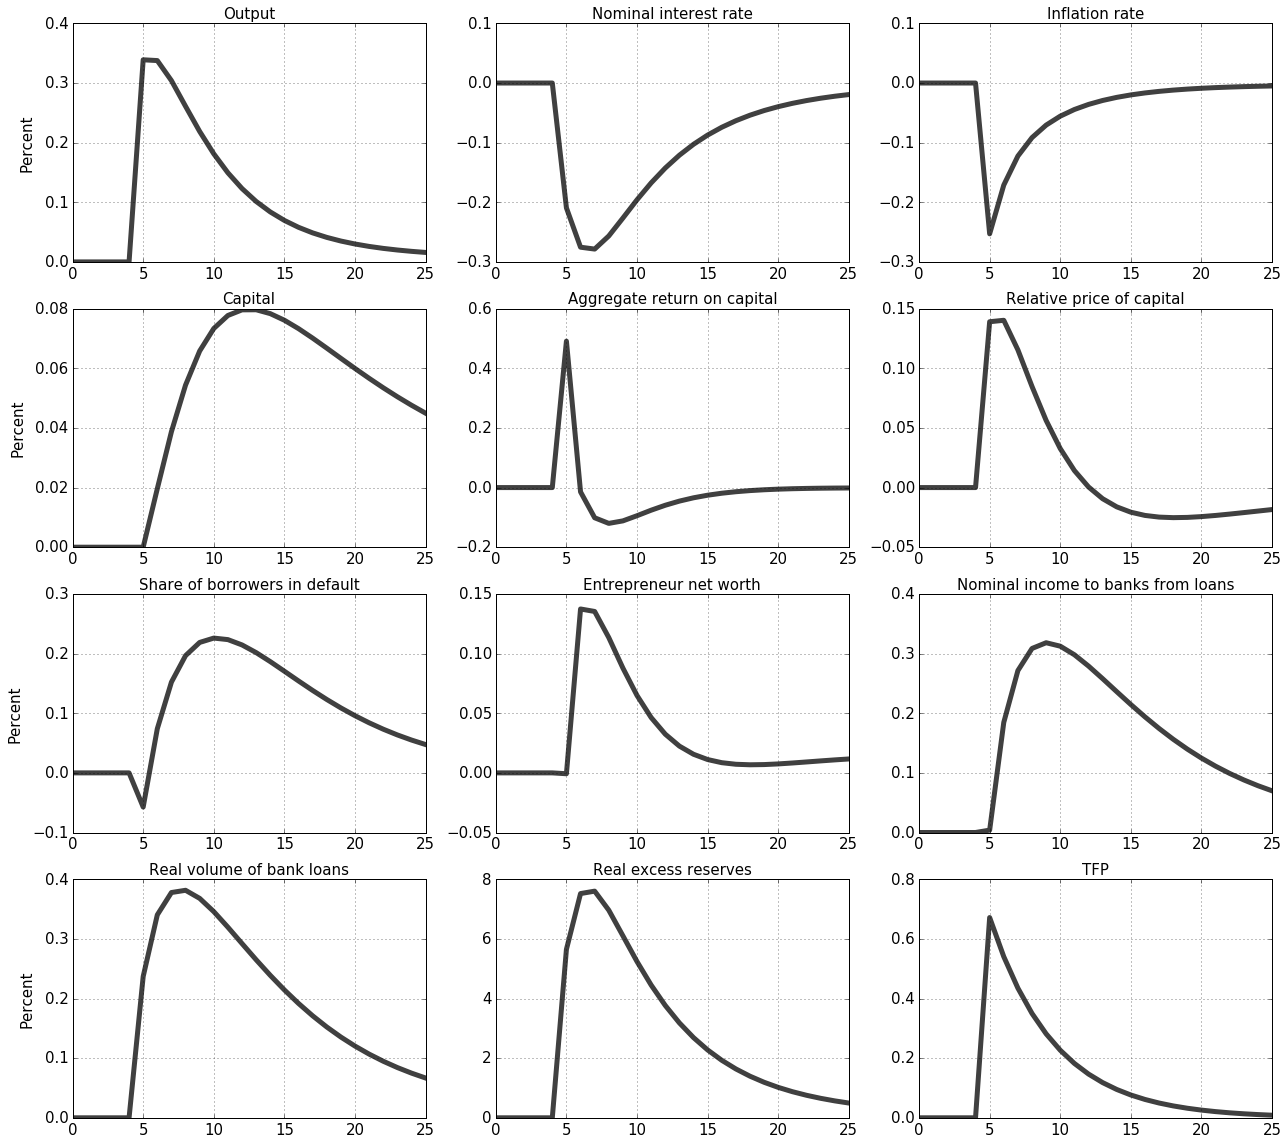

In [25]:
# TFP shock 
fig = plt.figure(figsize=(18,16))
ax1 = fig.add_subplot(4,3,1)
(model_rab_main_figures.irs['e_z']['yf']/model_rab_main_figures.ss.yf*100).plot(color='k',lw=5,alpha=0.75,grid=True,ax=ax1)
ax1.locator_params(axis = 'y', nbins = 5)
ax1.set_title('Output',fontsize=15)
ax1.set_ylabel('Percent',fontsize=15,labelpad=10)

ax2 = fig.add_subplot(4,3,2)
(model_rab_main_figures.irs['e_z']['rn']*400).plot(color='k',lw=5,alpha=0.75,grid=True,ax=ax2)
ax2.set_title('Nominal interest rate',fontsize=15)
ax2.locator_params(axis = 'y', nbins = 5)

ax3 = fig.add_subplot(4,3,3)
(model_rab_main_figures.irs['e_z']['pi']*400).plot(color='k',lw=5,alpha=0.75,grid=True,ax=ax3)
ax3.set_title('Inflation rate',fontsize=15)
ax3.locator_params(axis = 'y', nbins = 5)


ax4 = fig.add_subplot(4,3,4)
(model_rab_main_figures.irs['e_z']['k']/model_rab_main_figures.ss.k*100).plot(color='k',lw=5,alpha=0.75,grid=True,ax=ax4)
ax4.set_title('Capital',fontsize=15)
ax4.locator_params(axis = 'y', nbins = 5)
ax4.set_ylabel('Percent',fontsize=15,labelpad=10)

ax5 = fig.add_subplot(4,3,5)
(model_rab_main_figures.irs['e_z']['rk']/model_rab_main_figures.ss.rk*400).plot(color='k',lw=5,alpha=0.75,grid=True,ax=ax5)
ax5.set_title('Aggregate return on capital',fontsize=15)
ax5.locator_params(axis = 'y', nbins = 5)

ax6 = fig.add_subplot(4,3,6)
(model_rab_main_figures.irs['e_z']['q']/model_rab_main_figures.ss.q*100).plot(color='k',lw=5,alpha=0.75,grid=True,ax=ax6)
ax6.set_title('Relative price of capital',fontsize=15)
ax6.locator_params(axis = 'y', nbins = 5)


ax7 = fig.add_subplot(4,3,7)
(model_rab_main_figures.irs['e_z']['wbar']/model_rab_main_figures.ss.wbar*100).plot(color='k',lw=5,alpha=0.75,grid=True,ax=ax7)
ax7.set_title('Share of borrowers in default',fontsize=15)
ax7.locator_params(axis = 'y', nbins = 5)
ax7.set_ylabel('Percent',fontsize=15,labelpad=10)

ax8 = fig.add_subplot(4,3,8)
(model_rab_main_figures.irs['e_z']['n']/model_rab_main_figures.ss.n*100).plot(color='k',lw=5,alpha=0.75,grid=True,ax=ax8)
ax8.set_title('Entrepreneur net worth',fontsize=15)
ax8.locator_params(axis = 'y', nbins = 5)

ax9 = fig.add_subplot(4,3,9)
(model_rab_main_figures.irs['e_z']['chi']/model_rab_main_figures.ss.chi*100).plot(color='k',lw=5,alpha=0.75,grid=True,ax=ax9)
ax9.set_title('Nominal income to banks from loans',fontsize=15)
ax9.locator_params(axis = 'y', nbins = 5)


ax10 = fig.add_subplot(4,3,10)
(model_rab_main_figures.irs['e_z']['b']/model_rab_main_figures.ss.b*100).plot(color='k',lw=5,alpha=0.75,grid=True,ax=ax10)
ax10.set_title('Real volume of bank loans',fontsize=15)
ax10.locator_params(axis = 'y', nbins = 5)
ax10.set_ylabel('Percent',fontsize=15,labelpad=10)

ax11 = fig.add_subplot(4,3,11)
(model_rab_main_figures.irs['e_z']['mex']/model_rab_main_figures.ss.mex*100).plot(color='k',lw=5,alpha=0.75,grid=True,ax=ax11)
ax11.set_title('Real excess reserves',fontsize=15)
ax11.locator_params(axis = 'y', nbins = 5)

ax12 = fig.add_subplot(4,3,12)
(model_rab_main_figures.irs['e_z']['z']*100).plot(color='k',lw=5,alpha=0.75,grid=True,ax=ax12)
ax12.set_title('TFP',fontsize=15)
ax12.locator_params(axis = 'y', nbins = 5)

fig.tight_layout()

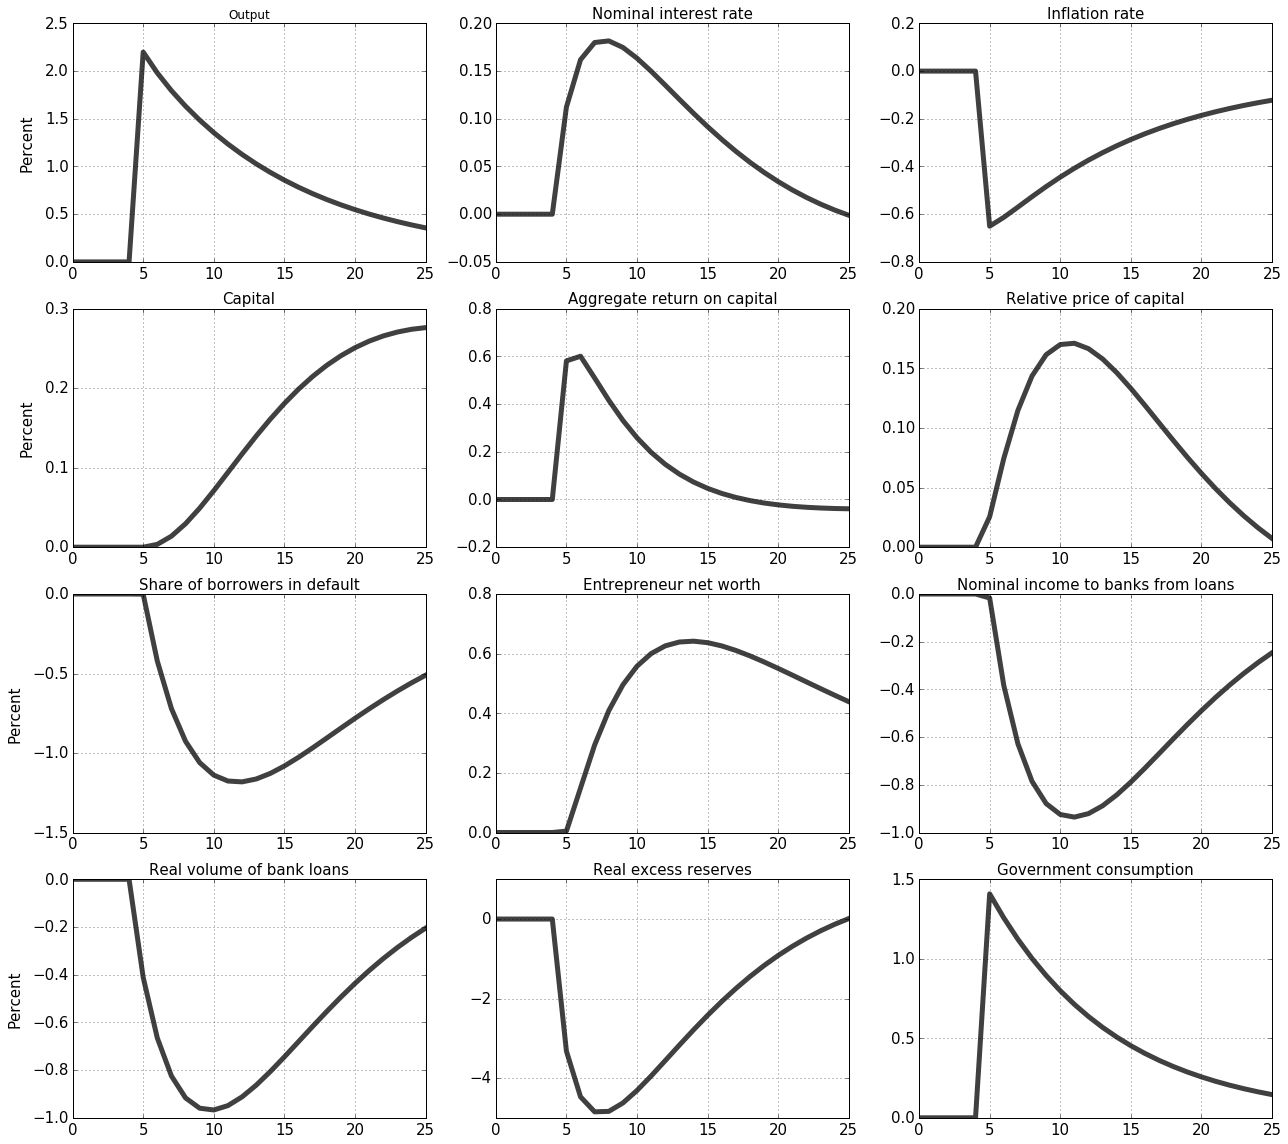

In [26]:
# Government consumption shock
fig = plt.figure(figsize=(18,16))
ax1 = fig.add_subplot(4,3,1)
(model_rab_main_figures.irs['e_g']['yf']/model_rab_main_figures.ss.yf*100).plot(color='k',lw=5,alpha=0.75,grid=True,ax=ax1)
ax1.set_title('Output')
ax1.locator_params(axis = 'y', nbins = 5)
ax1.set_ylabel('Percent',fontsize=15,labelpad=10)

ax2 = fig.add_subplot(4,3,2)
(model_rab_main_figures.irs['e_g']['rn']/model_rab_main_figures.ss.rn*400).plot(color='k',lw=5,alpha=0.75,grid=True,ax=ax2)
ax2.set_title('Nominal interest rate',fontsize=15)
ax2.locator_params(axis = 'y', nbins = 5)

ax3 = fig.add_subplot(4,3,3)
(model_rab_main_figures.irs['e_g']['pi']/model_rab_main_figures.ss.pi*400).plot(color='k',lw=5,alpha=0.75,grid=True,ax=ax3)
ax3.set_title('Inflation rate',fontsize=15)
ax3.locator_params(axis = 'y', nbins = 5)


ax4 = fig.add_subplot(4,3,4)
(model_rab_main_figures.irs['e_g']['k']/model_rab_main_figures.ss.k*100).plot(color='k',lw=5,alpha=0.75,grid=True,ax=ax4)
ax4.set_title('Capital',fontsize=15)
ax4.locator_params(axis = 'y', nbins = 5)
ax4.set_ylabel('Percent',fontsize=15,labelpad=10)

ax5 = fig.add_subplot(4,3,5)
(model_rab_main_figures.irs['e_g']['rk']/model_rab_main_figures.ss.rk*400).plot(color='k',lw=5,alpha=0.75,grid=True,ax=ax5)
ax5.set_title('Aggregate return on capital',fontsize=15)
ax5.locator_params(axis = 'y', nbins = 5)

ax6 = fig.add_subplot(4,3,6)
(model_rab_main_figures.irs['e_g']['q']/model_rab_main_figures.ss.q*100).plot(color='k',lw=5,alpha=0.75,grid=True,ax=ax6)
ax6.set_title('Relative price of capital',fontsize=15)
ax6.locator_params(axis = 'y', nbins = 5)


ax7 = fig.add_subplot(4,3,7)
(model_rab_main_figures.irs['e_g']['wbar']/model_rab_main_figures.ss.wbar*100).plot(color='k',lw=5,alpha=0.75,grid=True,ax=ax7)
ax7.set_title('Share of borrowers in default',fontsize=15)
ax7.locator_params(axis = 'y', nbins = 5)
ax7.set_ylabel('Percent',fontsize=15,labelpad=10)

ax8 = fig.add_subplot(4,3,8)
(model_rab_main_figures.irs['e_g']['n']/model_rab_main_figures.ss.n*100).plot(color='k',lw=5,alpha=0.75,grid=True,ax=ax8)
ax8.set_title('Entrepreneur net worth',fontsize=15)
ax8.locator_params(axis = 'y', nbins = 5)

ax9 = fig.add_subplot(4,3,9)
(model_rab_main_figures.irs['e_g']['chi']/model_rab_main_figures.ss.chi*100).plot(color='k',lw=5,alpha=0.75,grid=True,ax=ax9)
ax9.set_title('Nominal income to banks from loans',fontsize=15)
ax9.locator_params(axis = 'y', nbins = 5)


ax10 = fig.add_subplot(4,3,10)
(model_rab_main_figures.irs['e_g']['b']/model_rab_main_figures.ss.b*100).plot(color='k',lw=5,alpha=0.75,grid=True,ax=ax10)
ax10.set_title('Real volume of bank loans',fontsize=15)
ax10.locator_params(axis = 'y', nbins = 5)
ax10.set_ylabel('Percent',fontsize=15,labelpad=10)

ax11 = fig.add_subplot(4,3,11)
(model_rab_main_figures.irs['e_g']['mex']/model_rab_main_figures.ss.mex*100).plot(color='k',lw=5,alpha=0.75,grid=True,ax=ax11)
ax11.set_title('Real excess reserves',fontsize=15)
ax11.locator_params(axis = 'y', nbins = 5)

ax12 = fig.add_subplot(4,3,12)
(model_rab_main_figures.irs['e_g']['g']*100).plot(color='k',lw=5,alpha=0.75,grid=True,ax=ax12)
ax12.set_title('Government consumption',fontsize=15)
ax12.locator_params(axis = 'y', nbins = 5)

fig.tight_layout()

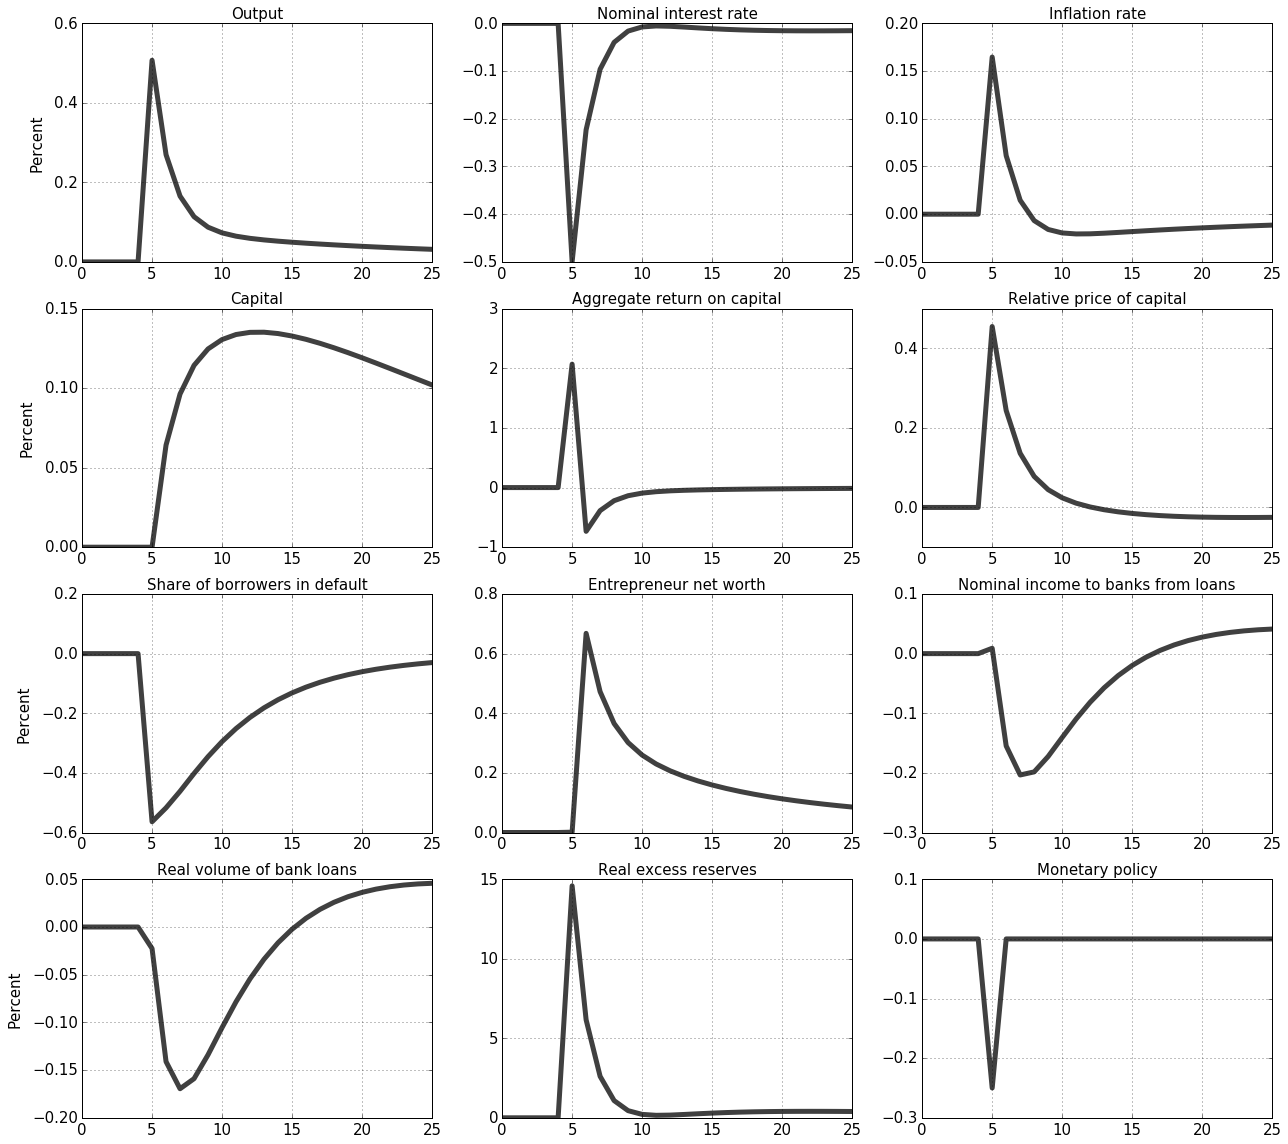

In [27]:
# Monetary policy shock
fig = plt.figure(figsize=(18,16))
ax1 = fig.add_subplot(4,3,1)
(model_rab_main_figures.irs['e_v']['yf']/model_rab_main_figures.ss.yf*100).plot(color='k',lw=5,alpha=0.75,grid=True,ax=ax1)
ax1.set_title('Output',fontsize=15)
ax1.locator_params(axis = 'y', nbins = 5)
ax1.set_ylabel('Percent',fontsize=15,labelpad=10)

ax2 = fig.add_subplot(4,3,2)
(model_rab_main_figures.irs['e_v']['rn']/model_rab_main_figures.ss.rn*400).plot(color='k',lw=5,alpha=0.75,grid=True,ax=ax2)
ax2.set_title('Nominal interest rate',fontsize=15)
ax2.locator_params(axis = 'y', nbins = 5)

ax3 = fig.add_subplot(4,3,3)
(model_rab_main_figures.irs['e_v']['pi']/model_rab_main_figures.ss.pi*400).plot(color='k',lw=5,alpha=0.75,grid=True,ax=ax3)
ax3.set_title('Inflation rate',fontsize=15)
ax3.locator_params(axis = 'y', nbins = 5)

ax4 = fig.add_subplot(4,3,4)
(model_rab_main_figures.irs['e_v']['k']/model_rab_main_figures.ss.k*100).plot(color='k',lw=5,alpha=0.75,grid=True,ax=ax4)
ax4.set_title('Capital',fontsize=15)
ax4.locator_params(axis = 'y', nbins = 5)
ax4.set_ylabel('Percent',fontsize=15,labelpad=10)

ax5 = fig.add_subplot(4,3,5)
(model_rab_main_figures.irs['e_v']['rk']/model_rab_main_figures.ss.rk*400).plot(color='k',lw=5,alpha=0.75,grid=True,ax=ax5)
ax5.set_title('Aggregate return on capital',fontsize=15)
ax5.locator_params(axis = 'y', nbins = 5)

ax6 = fig.add_subplot(4,3,6)
(model_rab_main_figures.irs['e_v']['q']/model_rab_main_figures.ss.q*100).plot(color='k',lw=5,alpha=0.75,grid=True,ax=ax6)
ax6.set_title('Relative price of capital',fontsize=15)
ax6.locator_params(axis = 'y', nbins = 5)

ax7 = fig.add_subplot(4,3,7)
(model_rab_main_figures.irs['e_v']['wbar']/model_rab_main_figures.ss.wbar*100).plot(color='k',lw=5,alpha=0.75,grid=True,ax=ax7)
ax7.set_title('Share of borrowers in default',fontsize=15)
ax7.locator_params(axis = 'y', nbins = 5)
ax7.set_ylabel('Percent',fontsize=15,labelpad=10)

ax8 = fig.add_subplot(4,3,8)
(model_rab_main_figures.irs['e_v']['n']/model_rab_main_figures.ss.n*100).plot(color='k',lw=5,alpha=0.75,grid=True,ax=ax8)
ax8.set_title('Entrepreneur net worth',fontsize=15)
ax8.locator_params(axis = 'y', nbins = 5)

ax9 = fig.add_subplot(4,3,9)
(model_rab_main_figures.irs['e_v']['chi']/model_rab_main_figures.ss.chi*100).plot(color='k',lw=5,alpha=0.75,grid=True,ax=ax9)
ax9.set_title('Nominal income to banks from loans',fontsize=15)
ax9.locator_params(axis = 'y', nbins = 5)



ax10 = fig.add_subplot(4,3,10)
(model_rab_main_figures.irs['e_v']['b']/model_rab_main_figures.ss.b*100).plot(color='k',lw=5,alpha=0.75,grid=True,ax=ax10)
ax10.set_title('Real volume of bank loans',fontsize=15)
ax10.locator_params(axis = 'y', nbins = 5)
ax10.set_ylabel('Percent',fontsize=15,labelpad=10)

ax11 = fig.add_subplot(4,3,11)
(model_rab_main_figures.irs['e_v']['mex']/model_rab_main_figures.ss.mex*100).plot(color='k',lw=5,alpha=0.75,grid=True,ax=ax11)
ax11.set_title('Real excess reserves',fontsize=15)
ax11.locator_params(axis = 'y', nbins = 5)

ax1.locator_params(axis = 'y', nbins = 5)
ax12 = fig.add_subplot(4,3,12)
(model_rab_main_figures.irs['e_v']['v']*100).plot(color='k',lw=5,alpha=0.75,grid=True,ax=ax12)
ax12.set_title('Monetary policy',fontsize=15)
ax12.locator_params(axis = 'y', nbins = 5)

fig.tight_layout()

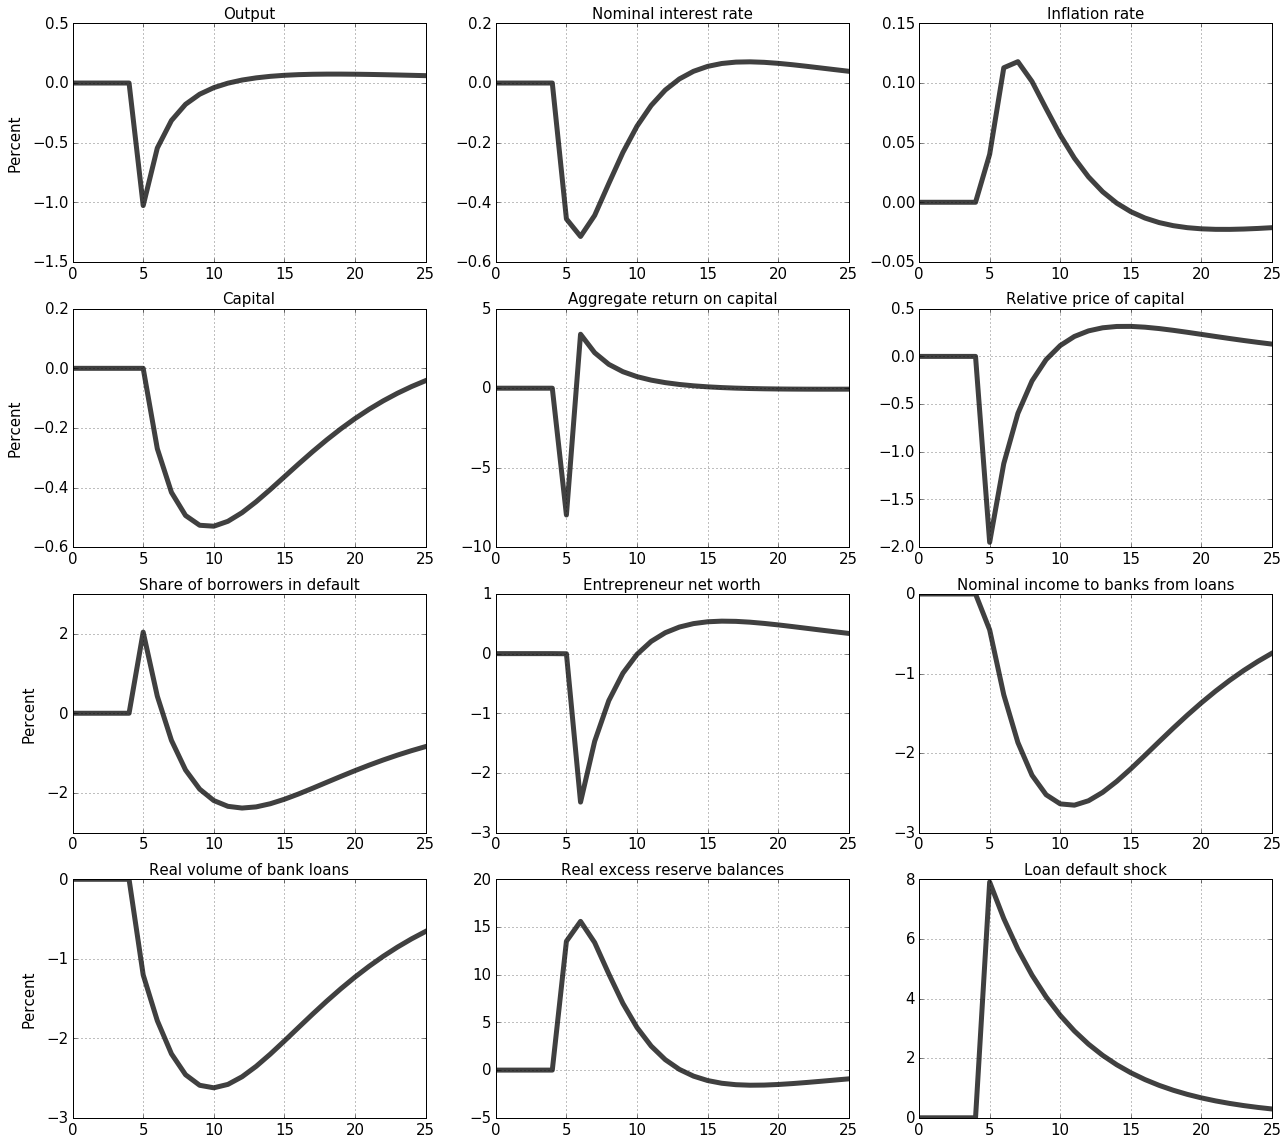

In [28]:
# Loan default shock
fig = plt.figure(figsize=(18,16))
ax1 = fig.add_subplot(4,3,1)
(model_rab_main_figures.irs['e_sw']['yf']/model_rab_main_figures.ss.yf*100).plot(color='k',lw=5,alpha=0.75,grid=True,ax=ax1)
ax1.set_title('Output',fontsize=15)
ax1.locator_params(axis = 'y', nbins = 5)
ax1.set_ylabel('Percent',fontsize=15,labelpad=10)

ax2 = fig.add_subplot(4,3,2)
(model_rab_main_figures.irs['e_sw']['rn']/model_rab_main_figures.ss.rn*400).plot(color='k',lw=5,alpha=0.75,grid=True,ax=ax2)
ax2.set_title('Nominal interest rate',fontsize=15)
ax2.locator_params(axis = 'y', nbins = 5)

ax3 = fig.add_subplot(4,3,3)
(model_rab_main_figures.irs['e_sw']['pi']/model_rab_main_figures.ss.pi*400).plot(color='k',lw=5,alpha=0.75,grid=True,ax=ax3)
ax3.set_title('Inflation rate',fontsize=15)
ax3.locator_params(axis = 'y', nbins = 5)


ax4 = fig.add_subplot(4,3,4)
(model_rab_main_figures.irs['e_sw']['k']/model_rab_main_figures.ss.k*100).plot(color='k',lw=5,alpha=0.75,grid=True,ax=ax4)
ax4.set_title('Capital',fontsize=15)
ax4.locator_params(axis = 'y', nbins = 5)
ax4.set_ylabel('Percent',fontsize=15,labelpad=10)

ax5 = fig.add_subplot(4,3,5)
(model_rab_main_figures.irs['e_sw']['rk']/model_rab_main_figures.ss.rk*400).plot(color='k',lw=5,alpha=0.75,grid=True,ax=ax5)
ax5.set_title('Aggregate return on capital',fontsize=15)
ax5.locator_params(axis = 'y', nbins = 5)

ax6 = fig.add_subplot(4,3,6)
(model_rab_main_figures.irs['e_sw']['q']/model_rab_main_figures.ss.q*100).plot(color='k',lw=5,alpha=0.75,grid=True,ax=ax6)
ax6.set_title('Relative price of capital',fontsize=15)
ax6.locator_params(axis = 'y', nbins = 5)


ax7 = fig.add_subplot(4,3,7)
(model_rab_main_figures.irs['e_sw']['wbar']/model_rab_main_figures.ss.wbar*100).plot(color='k',lw=5,alpha=0.75,grid=True,ax=ax7)
ax7.set_title('Share of borrowers in default',fontsize=15)
ax7.locator_params(axis = 'y', nbins = 5)
ax7.set_ylabel('Percent',fontsize=15,labelpad=10)

ax8 = fig.add_subplot(4,3,8)
(model_rab_main_figures.irs['e_sw']['n']/model_rab_main_figures.ss.n*100).plot(color='k',lw=5,alpha=0.75,grid=True,ax=ax8)
ax8.set_title('Entrepreneur net worth',fontsize=15)
ax8.locator_params(axis = 'y', nbins = 5)

ax9 = fig.add_subplot(4,3,9)
(model_rab_main_figures.irs['e_sw']['chi']/model_rab_main_figures.ss.chi*100).plot(color='k',lw=5,alpha=0.75,grid=True,ax=ax9)
ax9.set_title('Nominal income to banks from loans',fontsize=15)
ax9.locator_params(axis = 'y', nbins = 5)


ax10 = fig.add_subplot(4,3,10)
(model_rab_main_figures.irs['e_sw']['b']/model_rab_main_figures.ss.b*100).plot(color='k',lw=5,alpha=0.75,grid=True,ax=ax10)
ax10.set_title('Real volume of bank loans',fontsize=15)
ax10.locator_params(axis = 'y', nbins = 5)
ax10.set_ylabel('Percent',fontsize=15,labelpad=10)

ax11 = fig.add_subplot(4,3,11)
(model_rab_main_figures.irs['e_sw']['mex']/model_rab_main_figures.ss.mex*100).plot(color='k',lw=5,alpha=0.75,grid=True,ax=ax11)
ax11.set_title('Real excess reserve balances',fontsize=15)
ax11.locator_params(axis = 'y', nbins = 5)

ax12 = fig.add_subplot(4,3,12)
(model_rab_main_figures.irs['e_sw']['sigmaw']/model_rab_main_figures.ss.sigmaw*100).plot(color='k',lw=5,alpha=0.75,grid=True,ax=ax12)
ax12.set_title('Loan default shock',fontsize=15)
ax12.locator_params(axis = 'y', nbins = 5)

fig.tight_layout()

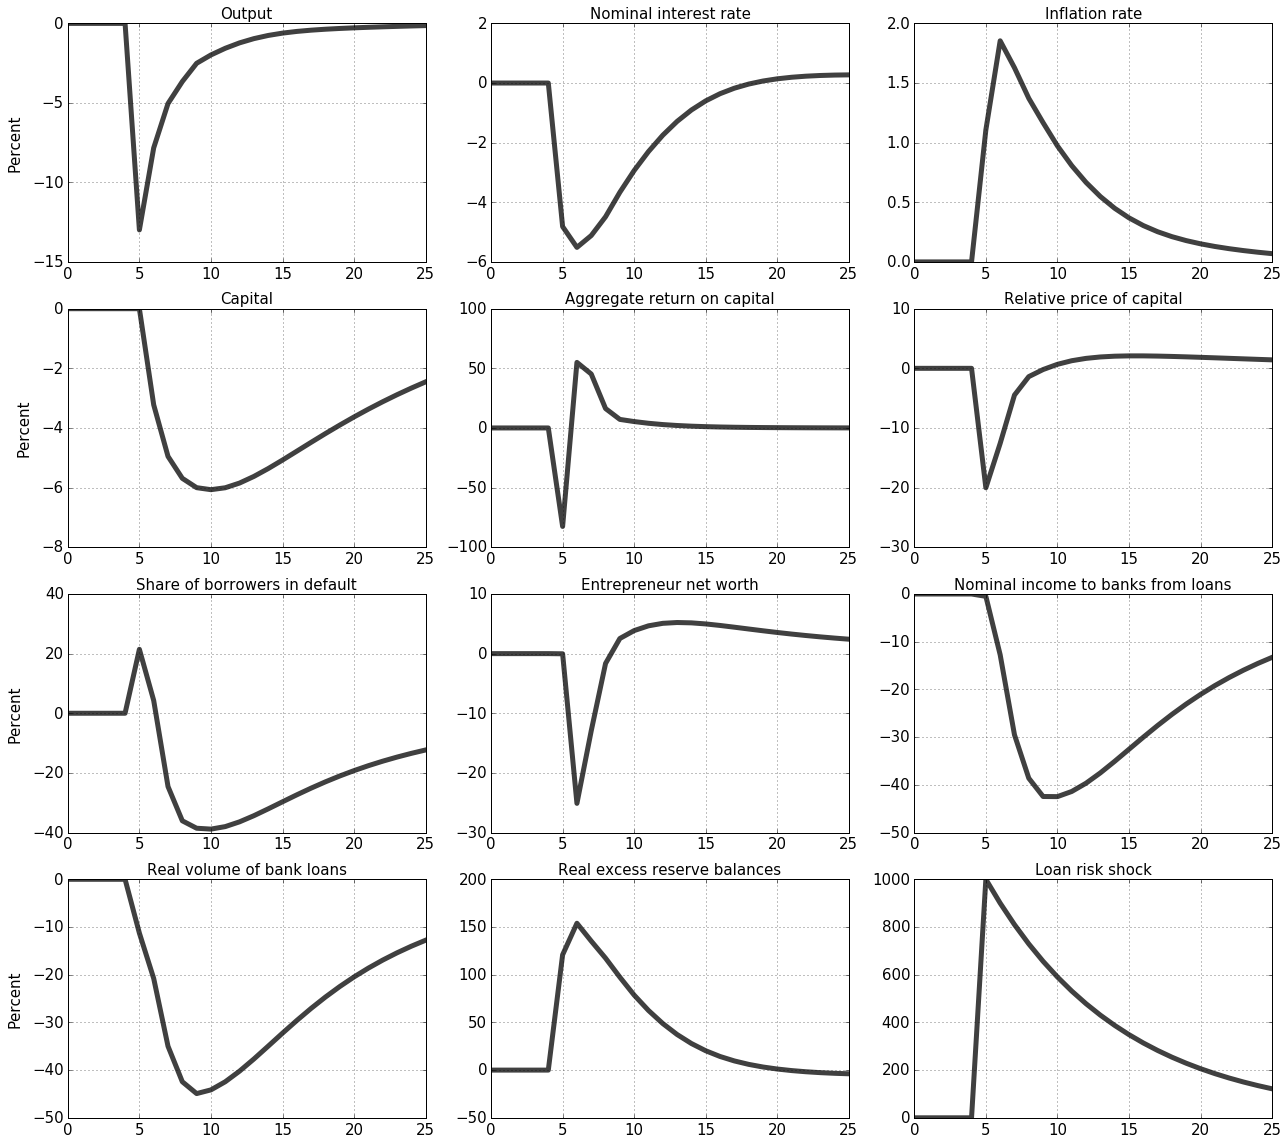

In [29]:
# Loan risk shock
fig = plt.figure(figsize=(18,16))
ax1 = fig.add_subplot(4,3,1)
(model_rab_main_figures.irs['e_ss']['yf']/model_rab_main_figures.ss.yf*100).plot(color='k',lw=5,alpha=0.75,grid=True,ax=ax1)
ax1.set_title('Output',fontsize=15)
ax1.locator_params(axis = 'y', nbins = 5)
ax1.set_ylabel('Percent',fontsize=15,labelpad=10)

ax2 = fig.add_subplot(4,3,2)
(model_rab_main_figures.irs['e_ss']['rn']/model_rab_main_figures.ss.rn*400).plot(color='k',lw=5,alpha=0.75,grid=True,ax=ax2)
ax2.set_title('Nominal interest rate',fontsize=15)
ax2.locator_params(axis = 'y', nbins = 5)

ax3 = fig.add_subplot(4,3,3)
(model_rab_main_figures.irs['e_ss']['pi']/model_rab_main_figures.ss.pi*400).plot(color='k',lw=5,alpha=0.75,grid=True,ax=ax3)
ax3.set_title('Inflation rate',fontsize=15)
ax3.locator_params(axis = 'y', nbins = 5)


ax4 = fig.add_subplot(4,3,4)
(model_rab_main_figures.irs['e_ss']['k']/model_rab_main_figures.ss.k*100).plot(color='k',lw=5,alpha=0.75,grid=True,ax=ax4)
ax4.set_title('Capital',fontsize=15)
ax4.locator_params(axis = 'y', nbins = 5)
ax4.set_ylabel('Percent',fontsize=15,labelpad=10)

ax5 = fig.add_subplot(4,3,5)
(model_rab_main_figures.irs['e_ss']['rk']/model_rab_main_figures.ss.rk*400).plot(color='k',lw=5,alpha=0.75,grid=True,ax=ax5)
ax5.set_title('Aggregate return on capital',fontsize=15)
ax5.locator_params(axis = 'y', nbins = 5)

ax6 = fig.add_subplot(4,3,6)
(model_rab_main_figures.irs['e_ss']['q']/model_rab_main_figures.ss.q*100).plot(color='k',lw=5,alpha=0.75,grid=True,ax=ax6)
ax6.set_title('Relative price of capital',fontsize=15)
ax6.locator_params(axis = 'y', nbins = 5)


ax7 = fig.add_subplot(4,3,7)
(model_rab_main_figures.irs['e_ss']['wbar']/model_rab_main_figures.ss.wbar*100).plot(color='k',lw=5,alpha=0.75,grid=True,ax=ax7)
ax7.set_title('Share of borrowers in default',fontsize=15)
ax7.locator_params(axis = 'y', nbins = 5)
ax7.set_ylabel('Percent',fontsize=15,labelpad=10)

ax8 = fig.add_subplot(4,3,8)
(model_rab_main_figures.irs['e_ss']['n']/model_rab_main_figures.ss.n*100).plot(color='k',lw=5,alpha=0.75,grid=True,ax=ax8)
ax8.set_title('Entrepreneur net worth',fontsize=15)
ax8.locator_params(axis = 'y', nbins = 5)

ax9 = fig.add_subplot(4,3,9)
(model_rab_main_figures.irs['e_ss']['chi']/model_rab_main_figures.ss.chi*100).plot(color='k',lw=5,alpha=0.75,grid=True,ax=ax9)
ax9.set_title('Nominal income to banks from loans',fontsize=15)
ax9.locator_params(axis = 'y', nbins = 5)


ax10 = fig.add_subplot(4,3,10)
(model_rab_main_figures.irs['e_ss']['b']/model_rab_main_figures.ss.b*100).plot(color='k',lw=5,alpha=0.75,grid=True,ax=ax10)
ax10.set_title('Real volume of bank loans',fontsize=15)
ax10.locator_params(axis = 'y', nbins = 5)
ax10.set_ylabel('Percent',fontsize=15,labelpad=10)

ax11 = fig.add_subplot(4,3,11)
(model_rab_main_figures.irs['e_ss']['mex']/model_rab_main_figures.ss.mex*100).plot(color='k',lw=5,alpha=0.75,grid=True,ax=ax11)
ax11.set_title('Real excess reserve balances',fontsize=15)
ax11.locator_params(axis = 'y', nbins = 5)

ax12 = fig.add_subplot(4,3,12)
(model_rab_main_figures.irs['e_ss']['sigmas']*100).plot(color='k',lw=5,alpha=0.75,grid=True,ax=ax12)
ax12.set_title('Loan risk shock',fontsize=15)
ax12.locator_params(axis = 'y', nbins = 5)

fig.tight_layout()

### Compare RAB and BGG models

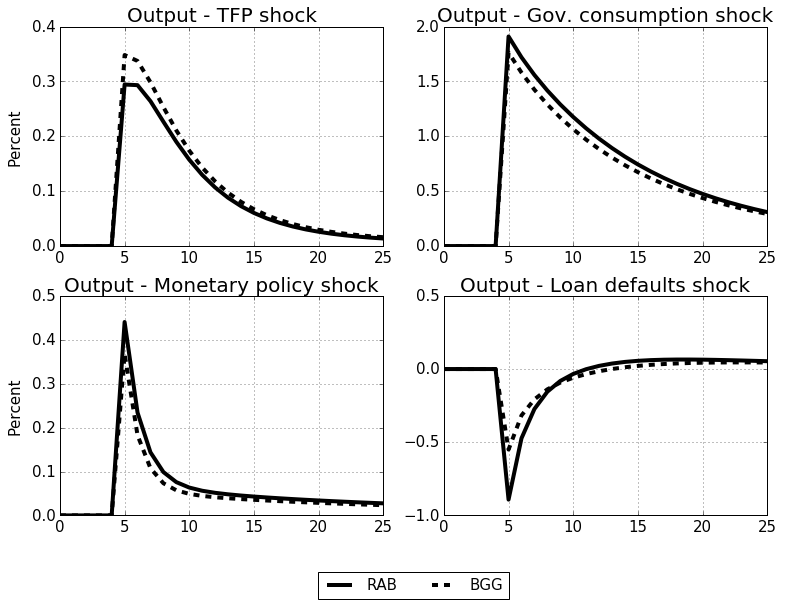

In [30]:
# Compare RAB and BGG models
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(2,2,1)
(model_rab_main_figures.irs['e_z']['yf']/computed_ss_rab_xi_phi_100.yf*100).plot(lw=4,linestyle='-',alpha=1,c='k',grid=True,ax=ax,label='RAB')
(model_bgg.irs['e_z']['yf']/computed_ss_bgg.yf*100).plot(lw=4,linestyle='--',c='k',alpha=1,grid=True,ax=ax,label='BGG')
ax.set_title('Output - TFP shock',fontsize=20)
ax.locator_params(axis = 'y', nbins = 5)
ax.set_ylabel('Percent',fontsize=15,labelpad=10)

ax = fig.add_subplot(2,2,2)
(model_rab_main_figures.irs['e_g']['yf']/computed_ss_rab_xi_phi_100.yf*100).plot(lw=4,linestyle='-',alpha=1,c='k',grid=True,ax=ax,label='RAB')
(model_bgg.irs['e_g']['yf']/computed_ss_bgg.yf*100).plot(lw=4,linestyle='--',c='k',alpha=1,grid=True,ax=ax,label='BGG')
ax.set_title('Output - Gov. consumption shock',fontsize=20)
ax.locator_params(axis = 'y', nbins = 5)

ax = fig.add_subplot(2,2,3)
(model_rab_main_figures.irs['e_v']['yf']/computed_ss_rab_xi_phi_100.yf*100).plot(lw=4,linestyle='-',alpha=1,c='k',grid=True,ax=ax,label='RAB')
(model_bgg.irs['e_v']['yf']/computed_ss_bgg.yf*100).plot(lw=4,linestyle='--',c='k',alpha=1,grid=True,ax=ax,label='BGG')
ax.set_title('Output - Monetary policy shock',fontsize=20)
ax.locator_params(axis = 'y', nbins = 5)
ax.set_ylabel('Percent',fontsize=15,labelpad=10)

ax = fig.add_subplot(2,2,4)
(model_rab_main_figures.irs['e_sw']['yf']/computed_ss_rab_xi_phi_100.yf*100).plot(lw=4,linestyle='-',alpha=1,c='k',grid=True,ax=ax,label='RAB')
(model_bgg.irs['e_sw']['yf']/computed_ss_bgg.yf*100).plot(lw=4,linestyle='--',c='k',alpha=1,grid=True,ax=ax,label='BGG')
ax.set_title('Output - Loan defaults shock',fontsize=20)
ax.locator_params(axis = 'y', nbins = 5)

ax = fig.add_subplot(1,1,1)
ax.plot([],[],lw=4,linestyle='-',c='k',label='RAB')
ax.plot([],[],lw=4,linestyle='--',c='k',alpha=1,label='BGG')
ax.legend(loc=9, bbox_to_anchor=(0.5, -0.1),ncol=2,fontsize=15)
ax.axis('off')

fig.tight_layout()

### Demonstrate the effect of increasing risk aversion

RAB model simulated for $\xi_{\Phi}=1$, $\xi_{\Phi}=20$, $\xi_{\Phi}=50$, and $\xi_{\Phi}=100$.

In [31]:
shocks = pd.Series()
shocks['e_z'] = sig_z
shocks['e_g'] = sig_g
shocks['e_v'] = -0.01/4
shocks['e_sw'] = 0.0331
shocks['e_ss'] = 1

T = 26
t0 = 5

model_rab_xi_phi_1.impulse(t0=t0,T = T,shocks = shocks)
model_rab_xi_phi_10.impulse(t0=t0,T = T,shocks = shocks)
model_rab_xi_phi_20.impulse(t0=t0,T = T,shocks = shocks)
model_rab_xi_phi_100.impulse(t0=t0,T = T,shocks = shocks)
model_rab_xi_phi_50.impulse(t0=t0,T = T,shocks = shocks)

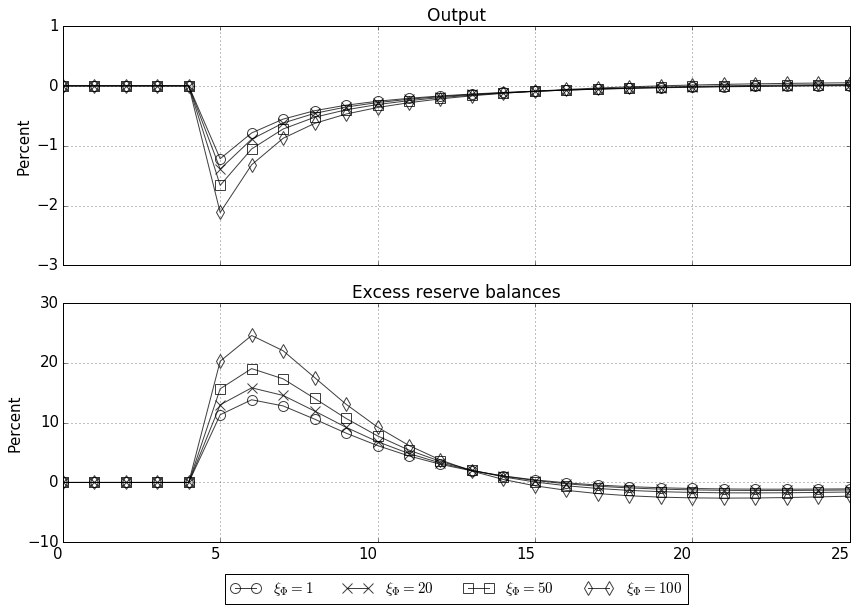

In [32]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(2,1,1)
(model_rab_xi_phi_1.irs['e_ss']['yf']/model_rab_xi_phi_1.ss.yf*100).plot(lw=1,marker='o',markeredgewidth=1,markeredgecolor='k',markerfacecolor='None',markersize=10,linestyle='-',alpha=0.75,color='k',grid=True,ax=ax,label='$\\xi_{\Phi} = 1$')
(model_rab_xi_phi_20.irs['e_ss']['yf']/model_rab_xi_phi_20.ss.yf*100).plot(lw=1,marker='x',markeredgewidth=1,markeredgecolor='k',markerfacecolor='None',markersize=10,linestyle='-',alpha=0.75,color='k',grid=True,ax=ax,label='$\\xi_{\Phi} = 20$')
(model_rab_xi_phi_50.irs['e_ss']['yf']/model_rab_xi_phi_50.ss.yf*100).plot(lw=1,marker='s',markeredgewidth=1,markeredgecolor='k',markerfacecolor='None',markersize=10,linestyle='-',alpha=0.75,color='k',grid=True,ax=ax,label='$\\xi_{\Phi} = 50$')
(model_rab_xi_phi_100.irs['e_ss']['yf']/model_rab_xi_phi_100.ss.yf*100).plot(lw=1,marker='d',markeredgewidth=1,markeredgecolor='k',markerfacecolor='None',markersize=10,linestyle='-',alpha=0.75,color='k',grid=True,ax=ax,label='$\\xi_{\Phi} = 100$')
ax.set_title('Output',fontsize=17)
ax.set_ylabel('Percent',fontsize=15)
ax.locator_params(axis = 'y', nbins = 5)

ax = fig.add_subplot(2,1,2)
(model_rab_xi_phi_1.irs['e_ss']['mex']/model_rab_xi_phi_1.ss.mex*100).plot(lw=1,marker='o',markeredgewidth=1,markeredgecolor='k',markerfacecolor='None',markersize=10,linestyle='-',alpha=0.75,color='k',grid=True,ax=ax,label='$\\xi_{\Phi} = 1$')
(model_rab_xi_phi_20.irs['e_ss']['mex']/model_rab_xi_phi_20.ss.mex*100).plot(lw=1,marker='x',markeredgewidth=1,markeredgecolor='k',markerfacecolor='None',markersize=10,linestyle='-',alpha=0.75,color='k',grid=True,ax=ax,label='$\\xi_{\Phi} = 20$')
(model_rab_xi_phi_50.irs['e_ss']['mex']/model_rab_xi_phi_50.ss.mex*100).plot(lw=1,marker='s',markeredgewidth=1,markeredgecolor='k',markerfacecolor='None',markersize=10,linestyle='-',alpha=0.75,color='k',grid=True,ax=ax,label='$\\xi_{\Phi} = 50$')
(model_rab_xi_phi_100.irs['e_ss']['mex']/model_rab_xi_phi_100.ss.mex*100).plot(lw=1,marker='d',markeredgewidth=1,markeredgecolor='k',markerfacecolor='None',markersize=10,linestyle='-',alpha=0.75,color='k',grid=True,ax=ax,label='$\\xi_{\Phi} = 100$')
ax.legend(loc=9, bbox_to_anchor=(0.5, -0.1),ncol=4,fontsize=15)
ax.set_title('Excess reserve balances',fontsize=17)
ax.set_ylabel('Percent',fontsize=15)
ax.set_ylim([-10,30])
ax.set_yticks([-10,0,10,20,30])

fig.autofmt_xdate(rotation = 0)
fig.tight_layout()